## [1] India ML Delinquency classification

In [4]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from collections import defaultdict
from collections import Counter 
from scipy.sparse import hstack
import operator

from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, SMOTENC, SVMSMOTE
from kmeans_smote import KMeansSMOTE

import string #for text pre-processing
import pickle

import warnings
warnings.filterwarnings("ignore")

import gc #Garbage collector.

In [5]:
import tensorflow as tf

In [134]:
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.metrics import precision_recall_curve, auc, roc_curve, hamming_loss, log_loss, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.preprocessing import normalize
from sklearn.preprocessing import PolynomialFeatures

from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

<h4> Settings for Pandas, Seaborn, CPU/GPU usage </h4>

In [7]:
tqdm.pandas()
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
sns.set(rc={'figure.figsize':(10, 5)})

In [8]:
pd.options.display.max_columns=50
pd.options.display.max_rows=100

In [9]:
GPU_AVAILABLE = tf.test.is_gpu_available()
print("GPU available:", GPU_AVAILABLE)

GPU available: False


### Data Dictionary

| Variable                | Description       |
|-------------------------|-------------------|    
|loan_id                  |	Unique loan ID    |
|source	|Loan origination channel
|financial_institution	|Name of the bank
|interest_rate	|Loan interest rate
|unpaid_principal_bal	|Loan unpaid principal balance
|loan_term	|Loan term (in days)
|origination_date	|Loan origination date
|first_payment_date	|First instalment payment date
|loan_to_value	|Loan to value ratio
|number_of_borrowers	|Number of borrowers
|debt_to_income_ratio	|Debt-to-income ratio
|borrower_credit_score	|Borrower credit score
|loan_purpose	|Loan purpose
|insurance_percent	|Loan Amount percent covered by insurance
|co-borrower_credit_score	|Co-borrower credit score
|insurance_type	|0 - Premium paid by borrower, 1 - Premium paid by Lender
|m1 to m12	|Month-wise loan performance (deliquency in months)
|m13	|target, loan deliquency status (0 = non deliquent, 1 = deliquent)  

### [1.1] Reading data and basic stats 

In [10]:
df_train = pd.read_csv("Train.csv")
df_test = pd.read_csv("Test.csv")

print("Number of data points in Train:",df_train.shape[0])
print("Number of data points in Test:",df_test.shape[0])

print(df_train.info())
print(df_test.info())

Number of data points in Train: 116058
Number of data points in Test: 35866
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116058 entries, 0 to 116057
Data columns (total 29 columns):
loan_id                     116058 non-null int64
source                      116058 non-null object
financial_institution       116058 non-null object
interest_rate               116058 non-null float64
unpaid_principal_bal        116058 non-null int64
loan_term                   116058 non-null int64
origination_date            116058 non-null object
first_payment_date          116058 non-null object
loan_to_value               116058 non-null int64
number_of_borrowers         116058 non-null float64
debt_to_income_ratio        116058 non-null float64
borrower_credit_score       116058 non-null float64
loan_purpose                116058 non-null object
insurance_percent           116058 non-null float64
co-borrower_credit_score    116058 non-null float64
insurance_type              116058 non-null fl

In [11]:
#Checking for duplicates.
print(df_train.duplicated(keep = False).any())
print(df_test.duplicated(keep = False).any())

False
False


In [12]:
#Applying datetime to 'origination_date' and 'first_payment_date'
df_train['origination_date'] = pd.to_datetime(df_train['origination_date'])
df_test['origination_date'] = pd.to_datetime(df_test['origination_date'])

df_train['first_payment_date'] = pd.to_datetime(df_train['first_payment_date'])
df_test['first_payment_date'] = pd.to_datetime(df_test['first_payment_date'], format='%b-%y')#For test it is in Apr-12 format.

### [2.1] Exploratory Data Analysis:

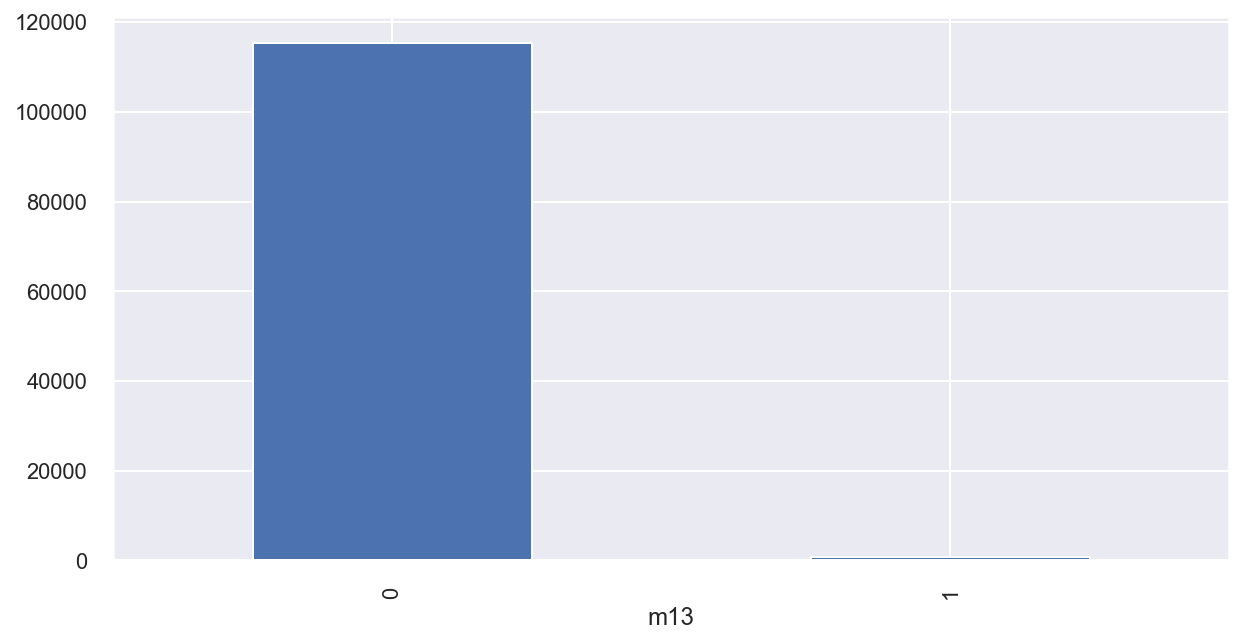

In [13]:
df_train.groupby("m13")['loan_id'].count().plot.bar()

- Train data seems highly imbalanced so F1 score metric will be the choosen metric.
- Since the '0' signifies non-delinquent our goal is to minimize False Negative rate.

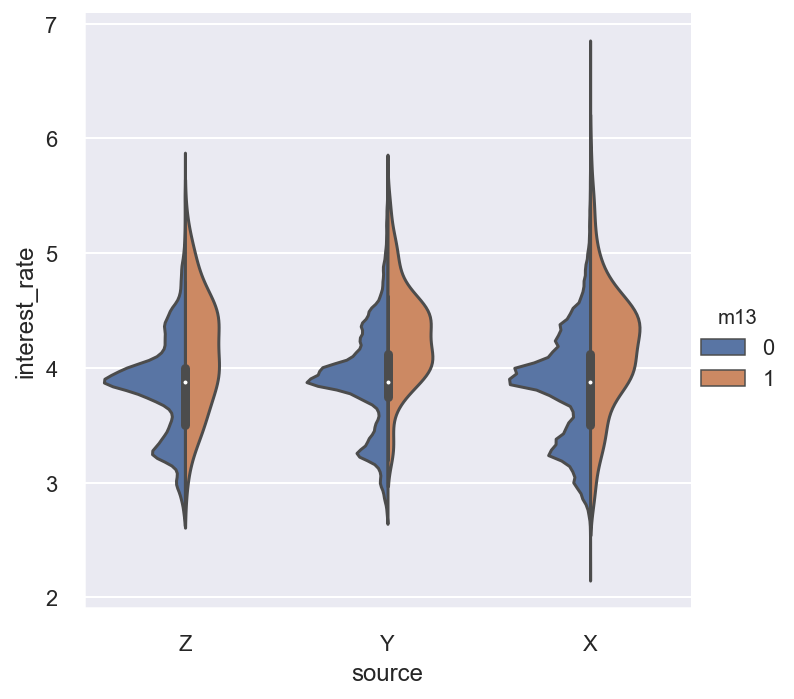

In [14]:
#df_train.groupby("m13")['org-first_payment_gap'].count().plot.bar()
sns.catplot(x="source", y="interest_rate", hue="m13", kind="violin", split=True, data=df_train);

- Interest rates for Delinquency tends be higher for all 3 sources.

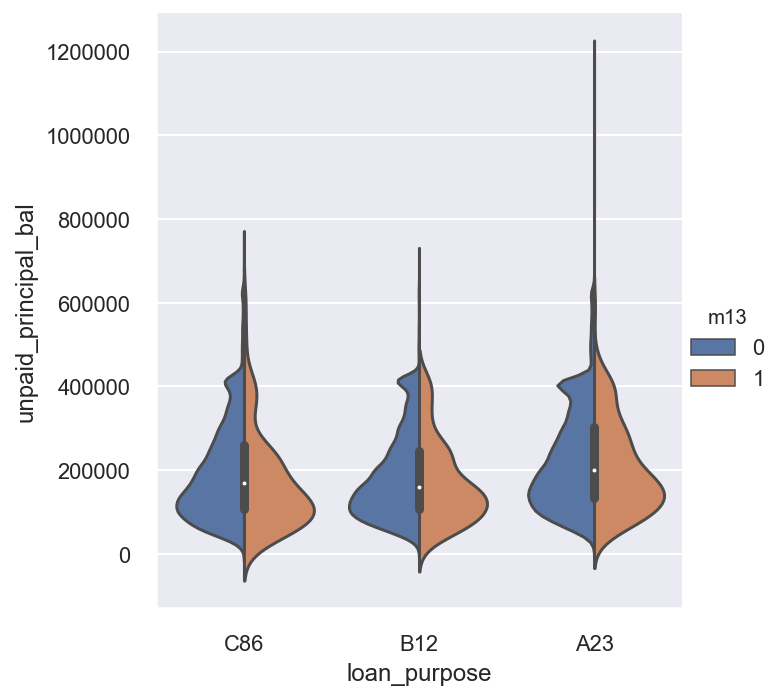

In [15]:
#df_train.groupby("m13")['org-first_payment_gap'].count().plot.bar()
sns.catplot(x="loan_purpose", y="unpaid_principal_bal", hue="m13", kind="violin", split=True, data=df_train);

- 'unpaid_principal_bal' doesn't seem to be good predictor of Delinquency.

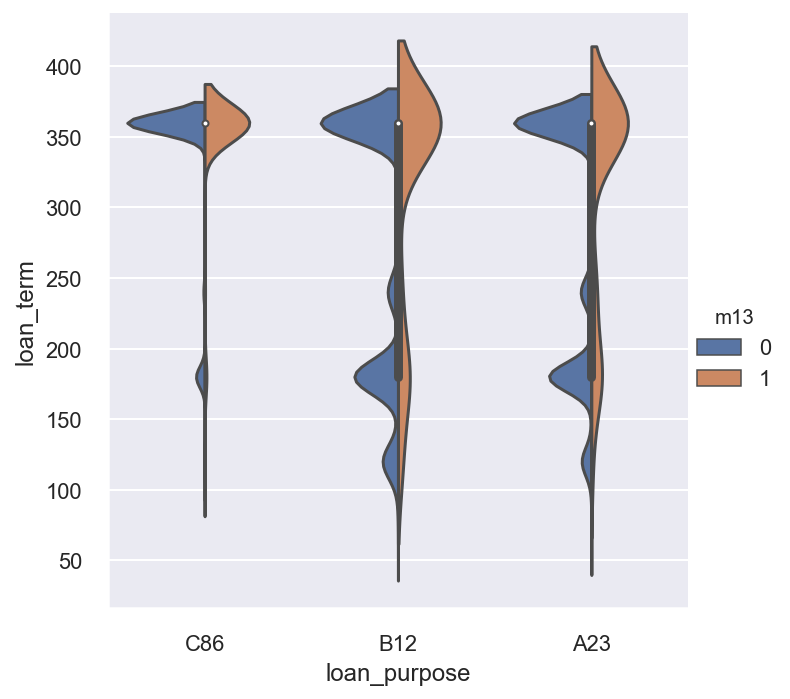

In [16]:
#df_train.groupby("m13")['org-first_payment_gap'].count().plot.bar()
sns.catplot(x="loan_purpose", y="loan_term", hue="m13", kind="violin", split=True, data=df_train);

- "loan_term" tend to be higher for all 3 "loan_purpose" for Delinquency.

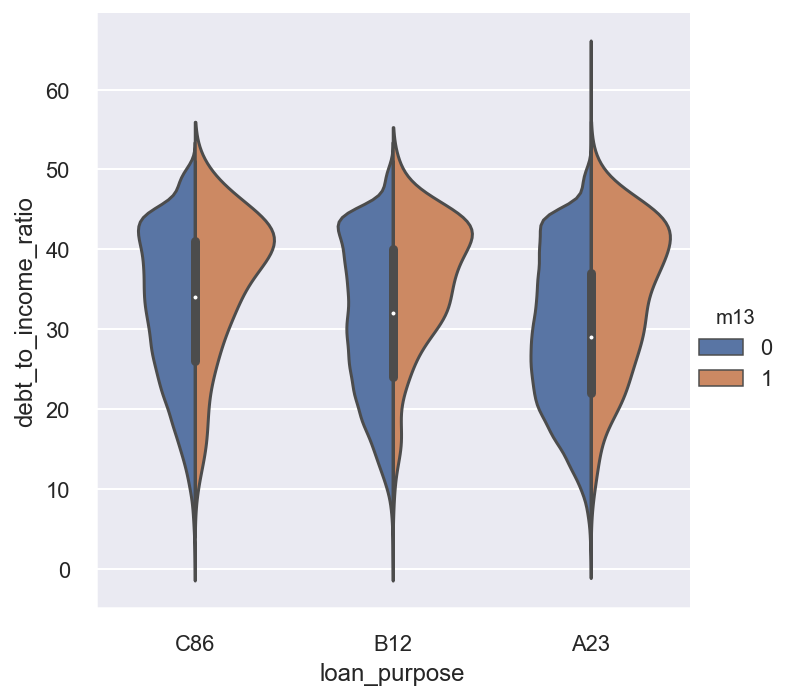

In [17]:
#df_train.groupby("m13")['org-first_payment_gap'].count().plot.bar()
sns.catplot(x="loan_purpose", y="debt_to_income_ratio", hue="m13", kind="violin", split=True, data=df_train);

- "debt_to_income_ratio" tend to be higher for Delinquency for "loan_purpose" B12 and A23.

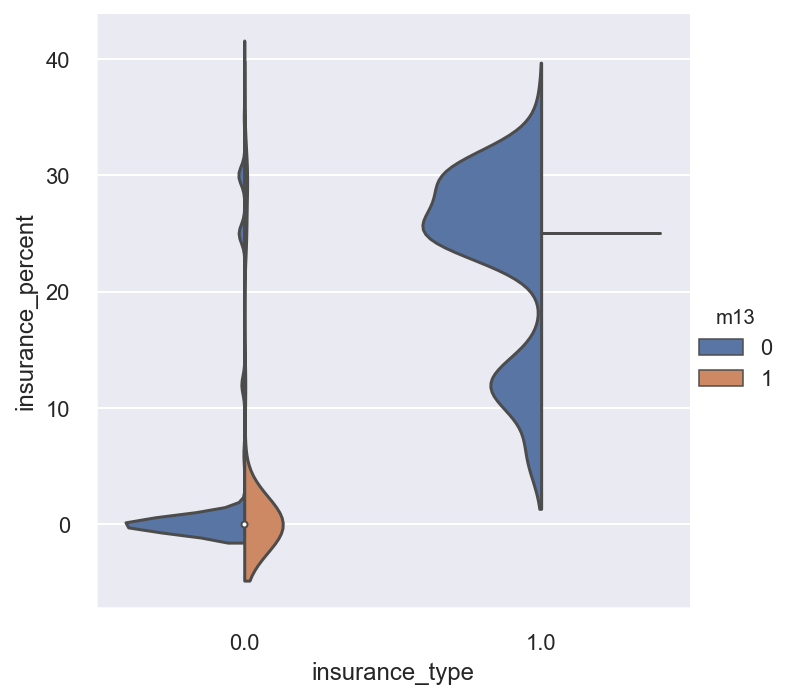

In [18]:
#df_train.groupby("m13")['org-first_payment_gap'].count().plot.bar()
sns.catplot(x="insurance_type", y="insurance_percent", hue="m13", kind="violin", split=True, data=df_train);

- Interestingly if the 'insurance_type' = 1 there no delinquency but if 'insurance_type' = 0, there is some delinquency.

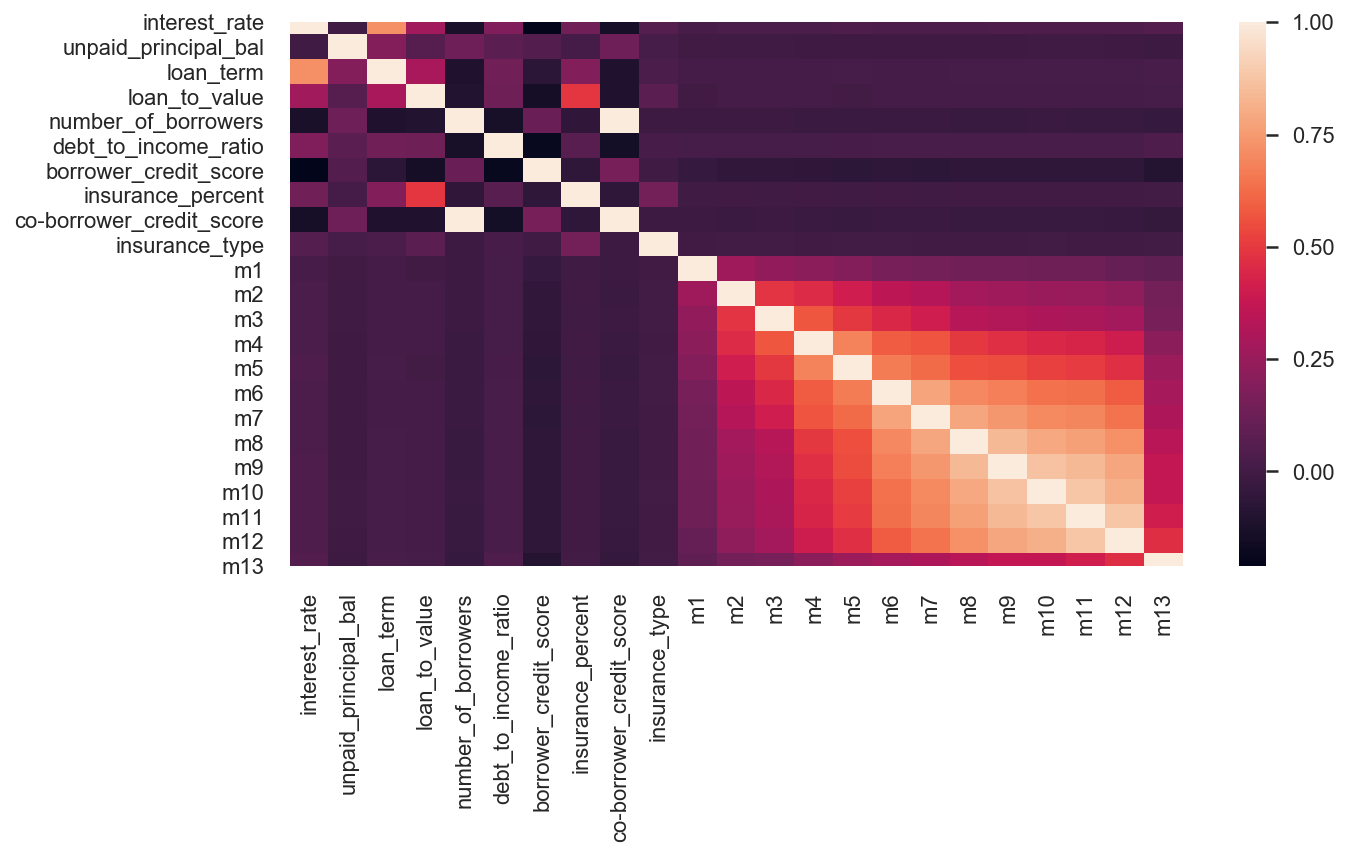

In [19]:
#sns.heatmap(pd.concat([df_train.drop('loan_id',axis=1),df_test]).corr())
sns.heatmap(df_train.drop('loan_id',axis=1).corr())

- 'number_of_borrowers' and 'co-borrower_credit_score' seems to be highly correlated, hence 'number_of_borrowers' will be dropped.
- Also correlation seems to increase in between monthly-wise loan performances in the 2nd half of the year.

In [20]:
test_loan_id = df_test['loan_id'] #Saving the Loan_id of test before dropping.

In [21]:
#dropping 'number_of_borrowers', loan_id  and date features from train and test.
df_train = df_train.drop(['loan_id','number_of_borrowers', 'origination_date','first_payment_date'],axis=1)
df_test = df_test.drop(['loan_id','number_of_borrowers', 'origination_date','first_payment_date'],axis=1)

In [22]:
#Checking for duplicates.
print(df_train.duplicated(keep = False).any())
print(df_test.duplicated(keep = False).any())

True
True


In [23]:
#Removing duplicated rows.
df_train = df_train.drop(df_train[df_train.duplicated(keep = "first")].index,axis=0)

In [24]:
cols = df_train.select_dtypes(include='object')
for i in cols:
    print("="*50)
    print(pd.crosstab(df_train[i],df_train['m13']))

m13         0    1
source            
X       63543  305
Y       37302  247
Z       14561   84
m13                              0    1
financial_institution                  
Anderson-Taylor                479    3
Browning-Hart                31673  175
Chapman-Mcmahon                388    0
Cole, Brooks and Vincent      1629   12
Edwards-Hoffman               4816   41
Martinez, Duffy and Bird      4692   23
Miller, Mcclure and Allen     3139   19
Nicholson Group               2105   11
OTHER                        49421  269
Richards-Walters              1454    5
Richardson Ltd                 472    1
Romero, Woods and Johnson      748    2
Sanchez, Hays and Wilkerson    850    2
Sanchez-Robinson              1192    1
Suarez Inc                    1785    5
Swanson, Newton and Miller    6828   46
Taylor, Hunt and Rodriguez    1255    4
Thornton-Davis                 648    3
Turner, Baldwin and Rhodes    1832   14
m13               0    1
loan_purpose            
A23           5

`Skewness` is usually described as a measure of a dataset’s symmetry – or lack of symmetry.   A perfectly symmetrical data set will have a skewness of 0. The normal distribution has a skewness of 0. If skewness is less than −1 or greater than +1, the distribution is highly skewed. If skewness is between −1 and −½ or between +½ and +1, the distribution is moderately skewed.

`Kurtosis` is a measure of the combined sizes of the two tails.  It measures the amount of probability in the tails.  The value is often compared to the kurtosis of the normal distribution, which is equal to 3.  If the kurtosis is greater than 3, then the dataset has heavier tails than a normal distribution (more in the tails).  If the kurtosis is less than 3, then the dataset has lighter tails than a normal distribution (less in the tails).

Skewness and kurtosis involve the tails of the distribution

In [25]:
# skewness & kurtosis
pd.DataFrame({"Skewness": df_train.skew(), "Kurtosis": df_train.kurt()})

,Skewness,Kurtosis
interest_rate,0.050940,0.169751
unpaid_principal_bal,0.897409,0.556806
loan_term,-0.692729,-1.293704
loan_to_value,-0.765140,0.077774
debt_to_income_ratio,-0.194314,-0.825148
borrower_credit_score,-3.570953,48.502118
insurance_percent,2.743432,5.869552
co-borrower_credit_score,-0.362418,-1.849943
insurance_type,17.435611,302.005750
m1,23.397861,665.602357


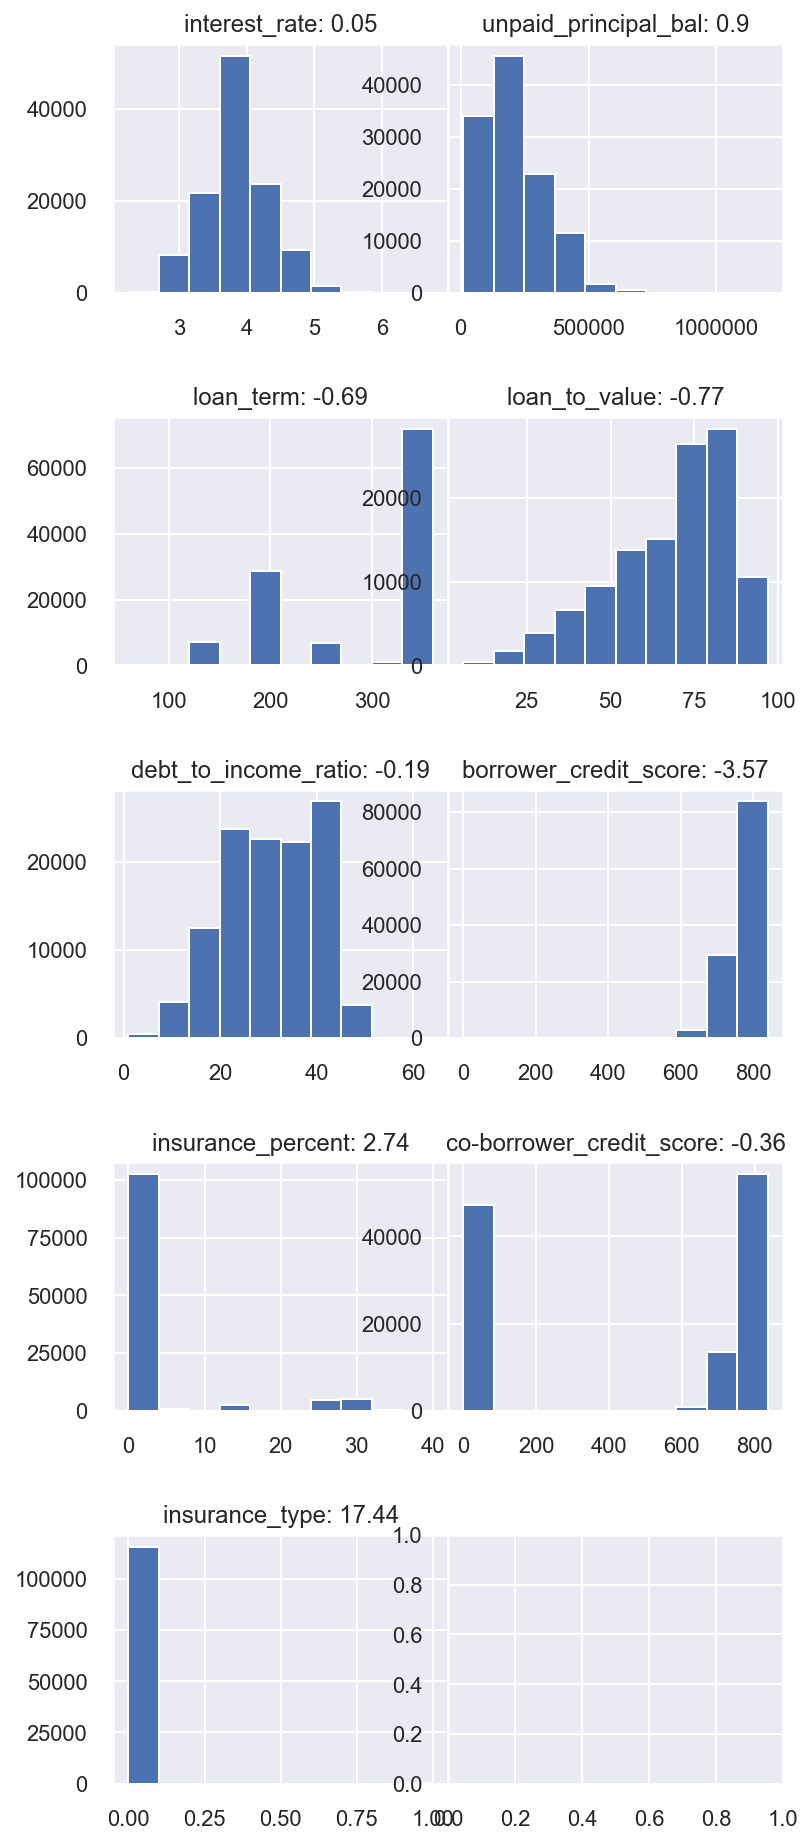

In [26]:
#Plotting histograms for 
fig, axs = plt.subplots(nrows=5,ncols=2, figsize=(6, 16), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i,j in zip([i for i in df_train.select_dtypes(exclude='object').columns.to_list() if len(i) >3],range(9)):
    axs[j].hist(df_train.select_dtypes(exclude='object')[i])
    axs[j].set_title(i+': '+str(np.round(df_train.select_dtypes(exclude='object')[i].skew(),2)))

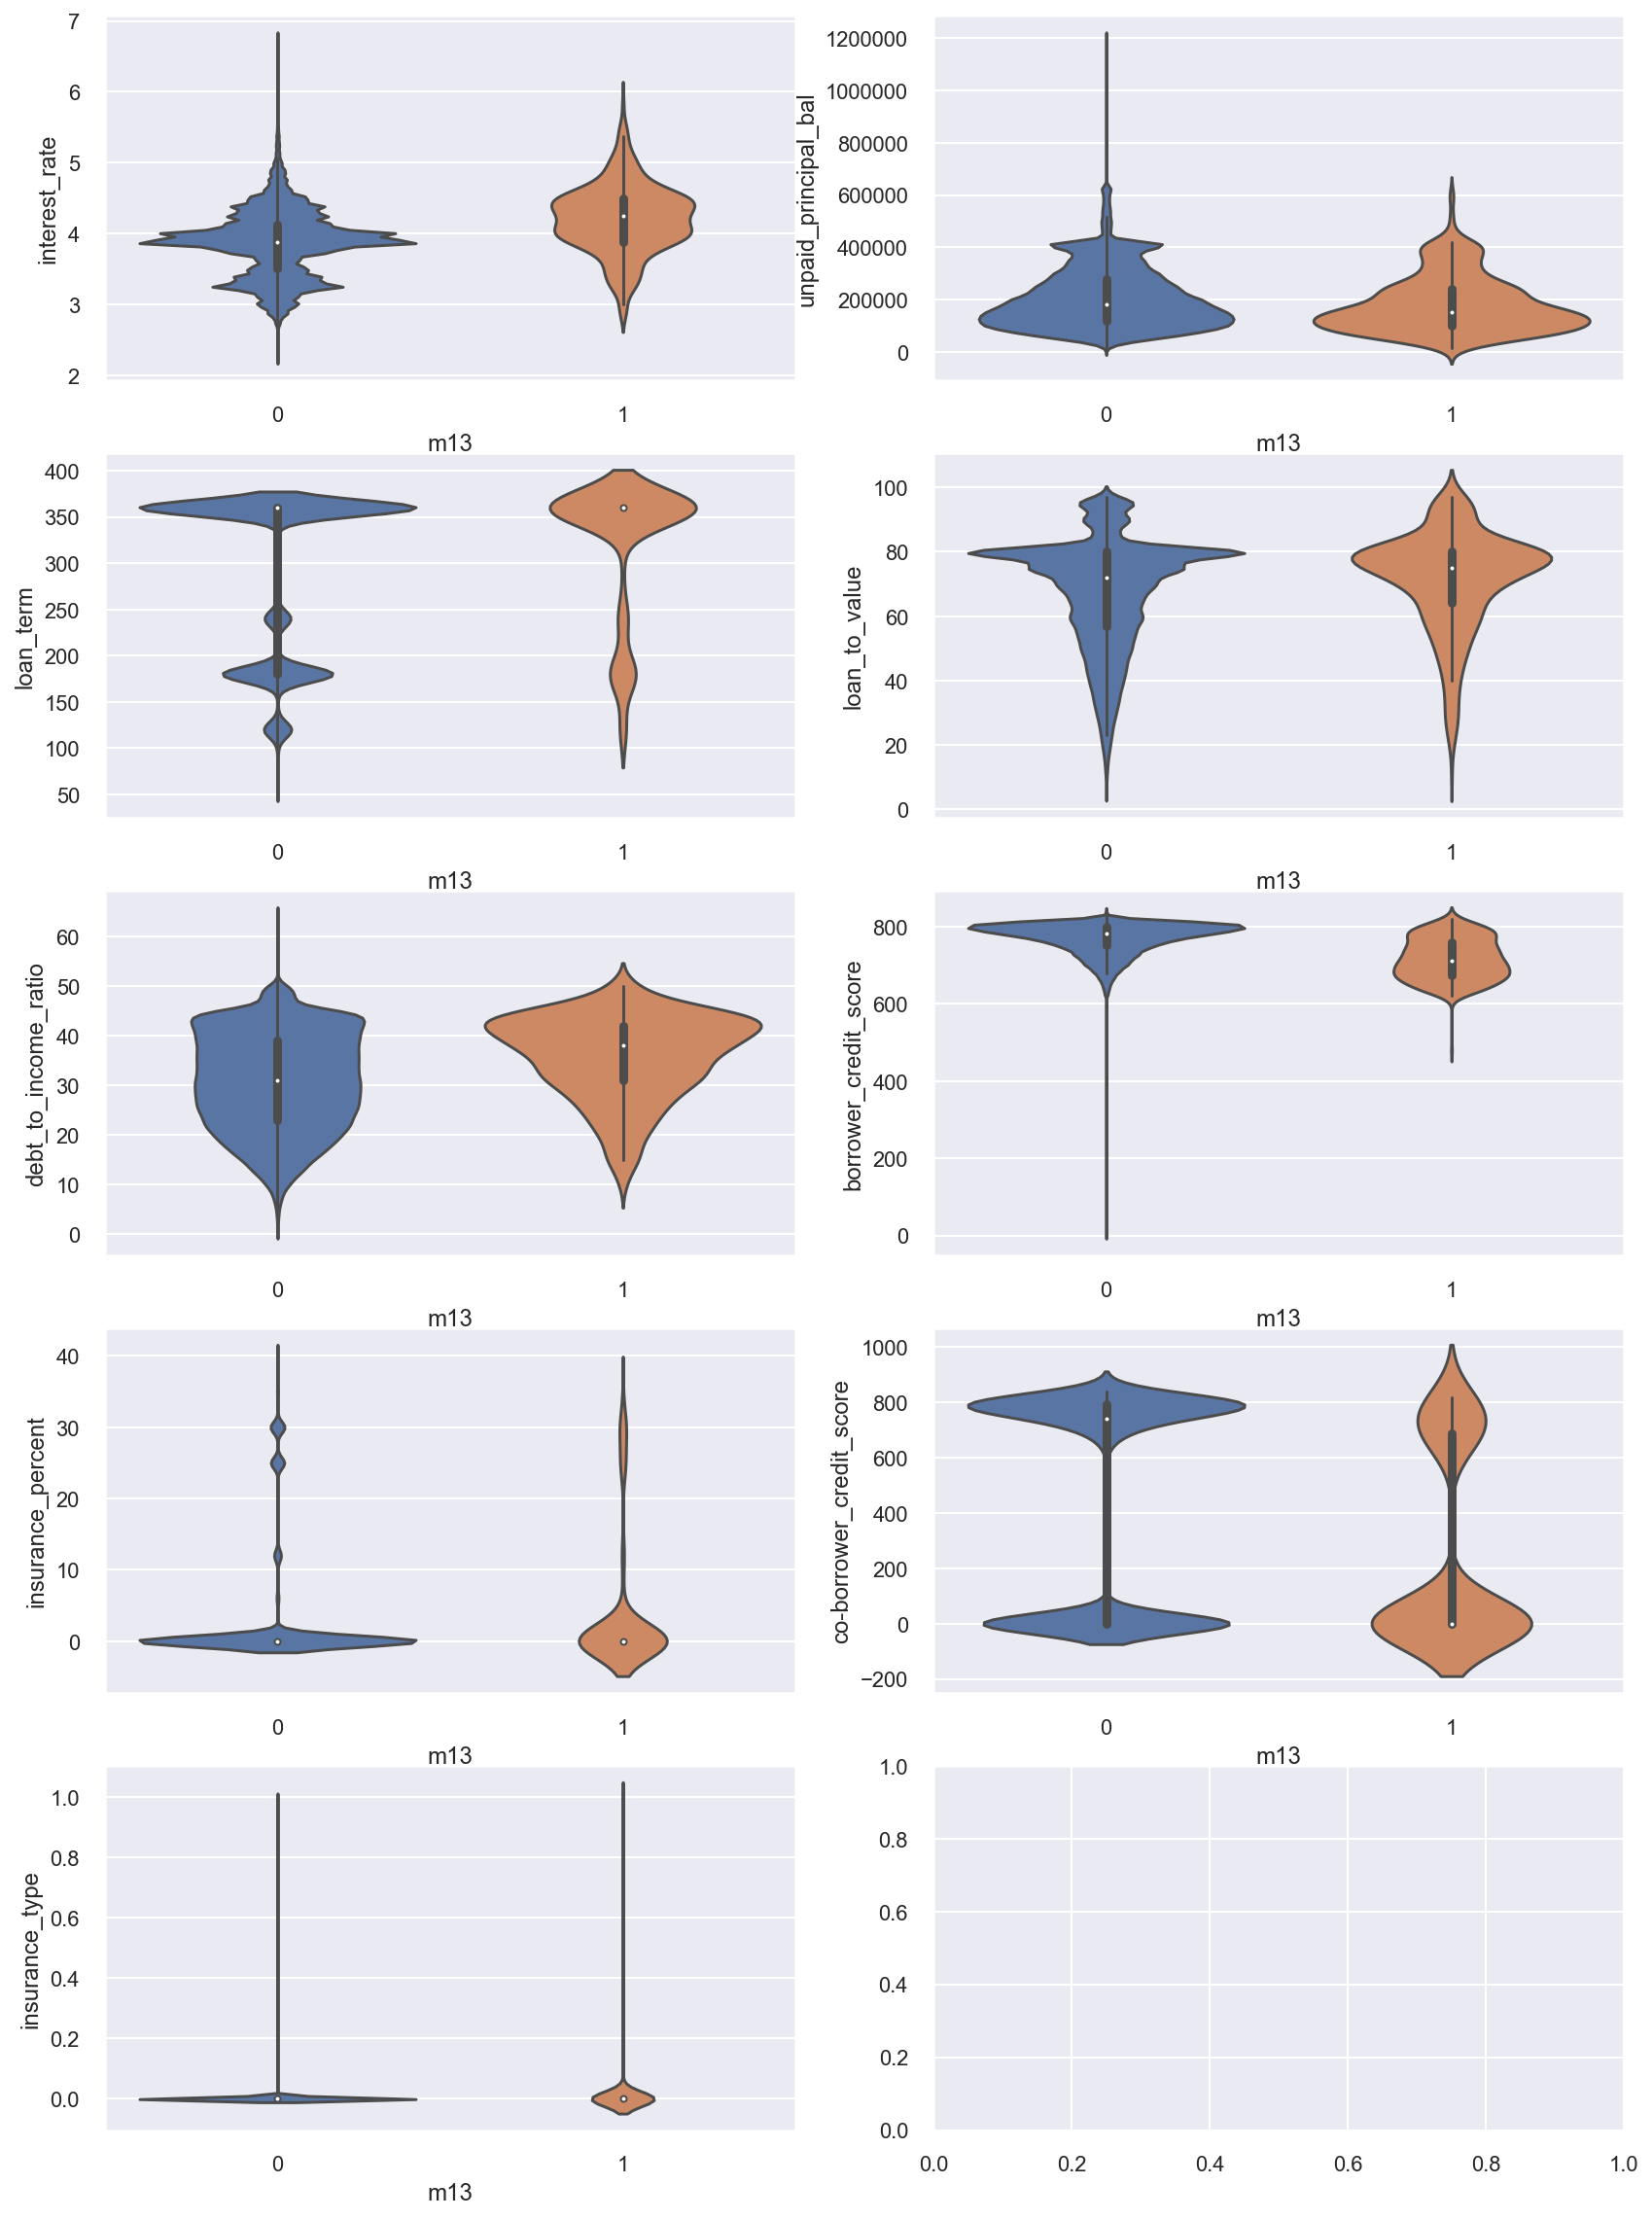

In [27]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(14,20))
axs = axs.ravel()

for i,j in zip([i for i in df_train.select_dtypes(exclude='object').columns.to_list() if len(i) >3],axs):
    sns.violinplot(x = 'm13', y = i, data =df_train.select_dtypes(exclude='object'),ax=j)

### [2.2] Oulier detection and removal (if any):

In [28]:
#Taking only 1st 9 numerical features, not considering monthly delinquency performance features.
num_features = df_train.select_dtypes(exclude=['object']).columns[:9].to_list()
print(num_features)
print([df_train[num_features[i]].dtype for i in range(len(num_features))])

['interest_rate', 'unpaid_principal_bal', 'loan_term', 'loan_to_value', 'debt_to_income_ratio', 'borrower_credit_score', 'insurance_percent', 'co-borrower_credit_score', 'insurance_type']
[dtype('float64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64')]


In [29]:
from pyod.models.lof import LOF

#resetting the index to remove outlier by capturing outliers by their row index.
df_train = df_train.reset_index(drop=True)
lof = LOF(n_neighbors=20, algorithm='auto', #uses knn algorithm to classify outliers and inliers.
          leaf_size=30, metric='minkowski', 
          p=2, metric_params=None, contamination=0.001, #Tunable percentage of outlier. P=2 is for euclidean distance.
          n_jobs=6)
lof.fit(df_train[num_features])

print(Counter(lof.predict(df_train[num_features]))) # 0:inlier, 1:outlier.
print(lof.decision_scores_) #Higher the decision score more likely the data-point is an outlier.

outlier_ix = np.argsort(lof.decision_scores_)[::-1][:Counter(lof.labels_)[1]] #Taking indices of the outliers.

Counter({0: 115932, 1: 110})
[1.31563938 1.04444888 1.79671733 ... 1.15799573 1.07551166 1.23644665]


In [30]:
lof.decision_scores_.shape

(116042,)

In [31]:
df_train = df_train.drop(index=outlier_ix,axis=0).reset_index(drop=True)

In [32]:
df_train.isna().any().any()

False

In [33]:
#Checking for duplicates.
print(df_train.duplicated(keep = False).any())

False


### [3.1] Feature engineering

#### [3.2] Polynomial features

In [273]:
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
poly_features_train = poly.fit_transform(df_train[num_features])
poly_features_test = poly.fit_transform(df_test[num_features])

print(poly_features_train.shape, poly_features_test.shape )

(115925, 45) (35866, 45)


In [274]:
poly_features_train = pd.DataFrame(poly_features_train, columns=poly.get_feature_names(input_features=num_features))
poly_features_train = poly_features_train.drop(num_features,axis=1)

poly_features_test = pd.DataFrame(poly_features_test, columns=poly.get_feature_names(input_features=num_features))
poly_features_test = poly_features_test.drop(num_features,axis=1)

In [275]:
poly_features_train.isna().any().any(), poly_features_test.isna().any().any()

(False, False)

In [276]:
df_train_poly = pd.concat([df_train, poly_features_train],axis=1)
df_train_poly.head(2)

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,...,unpaid_principal_bal borrower_credit_score,unpaid_principal_bal insurance_percent,unpaid_principal_bal co-borrower_credit_score,unpaid_principal_bal insurance_type,loan_term loan_to_value,loan_term debt_to_income_ratio,loan_term borrower_credit_score,loan_term insurance_percent,loan_term co-borrower_credit_score,loan_term insurance_type,loan_to_value debt_to_income_ratio,loan_to_value borrower_credit_score,loan_to_value insurance_percent,loan_to_value co-borrower_credit_score,loan_to_value insurance_type,debt_to_income_ratio borrower_credit_score,debt_to_income_ratio insurance_percent,debt_to_income_ratio co-borrower_credit_score,debt_to_income_ratio insurance_type,borrower_credit_score insurance_percent,borrower_credit_score co-borrower_credit_score,borrower_credit_score insurance_type,insurance_percent co-borrower_credit_score,insurance_percent insurance_type,co-borrower_credit_score insurance_type
0,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,95,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,...,148516000.0,6420000.0,0.0,0.0,34200.0,7920.0,249840.0,10800.0,0.0,0.0,2090.0,65930.0,2850.0,0.0,0.0,15268.0,660.0,0.0,0.0,20820.0,0.0,0.0,0.0,0.0,0.0
1,Y,"Swanson, Newton and Miller",4.875,144000,360,72,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1,...,100368000.0,0.0,0.0,0.0,25920.0,15840.0,250920.0,0.0,0.0,0.0,3168.0,50184.0,0.0,0.0,0.0,30668.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [277]:
df_train_poly.dropna().shape

(115925, 61)

In [278]:
df_test_poly = pd.concat([df_test, poly_features_test],axis=1)
df_test_poly.head(2)

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,interest_rate unpaid_principal_bal,...,unpaid_principal_bal borrower_credit_score,unpaid_principal_bal insurance_percent,unpaid_principal_bal co-borrower_credit_score,unpaid_principal_bal insurance_type,loan_term loan_to_value,loan_term debt_to_income_ratio,loan_term borrower_credit_score,loan_term insurance_percent,loan_term co-borrower_credit_score,loan_term insurance_type,loan_to_value debt_to_income_ratio,loan_to_value borrower_credit_score,loan_to_value insurance_percent,loan_to_value co-borrower_credit_score,loan_to_value insurance_type,debt_to_income_ratio borrower_credit_score,debt_to_income_ratio insurance_percent,debt_to_income_ratio co-borrower_credit_score,debt_to_income_ratio insurance_type,borrower_credit_score insurance_percent,borrower_credit_score co-borrower_credit_score,borrower_credit_score insurance_type,insurance_percent co-borrower_credit_score,insurance_percent insurance_type,co-borrower_credit_score insurance_type
0,Y,Browning-Hart,3.875,417000,360,75,20,790,A23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1615875.0,...,329430000.0,0.0,0.0,0.0,27000.0,7200.0,284400.0,0.0,0.0,0.0,1500.0,59250.0,0.0,0.0,0.0,15800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,X,OTHER,4.500,113000,360,80,33,793,C86,0,784,0,0,0,0,0,0,0,0,0,0,0,0,0,508500.0,...,89609000.0,0.0,88592000.0,0.0,28800.0,11880.0,285480.0,0.0,282240.0,0.0,2640.0,63440.0,0.0,62720.0,0.0,26169.0,0.0,25872.0,0.0,0.0,621712.0,0.0,0.0,0.0,0.0


In [279]:
print(df_train_poly.dropna().shape, df_test_poly.dropna().shape)
print(df_train_poly.isna().any().any(), df_test_poly.isna().any().any())

(115925, 61) (35866, 60)
False False


#### [3.3] Converting Categorical features to numeric(OHE)

In [280]:
df_train_poly.select_dtypes(include=['object']).head(2)

,source,financial_institution,loan_purpose
0,Z,"Turner, Baldwin and Rhodes",C86
1,Y,"Swanson, Newton and Miller",B12


In [281]:
categorical_columns = df_train_poly.select_dtypes(include=['object']).columns

In [282]:
#To convert categorical features to one-hot-encoded features.
def cat_to_ohe(train, test):
    d_train = pd.get_dummies(train, drop_first=False)  #pd.get_dummies() is the pandas method to covert cat features to ohe.
    d_test = pd.get_dummies(test, drop_first=False)
    # make sure that the number of features in train and test should be same
    for i in d_train.columns:
        if i not in d_test.columns:
            if i!='m13':
                d_train = d_train.drop(i, axis=1)
    for j in d_test.columns:
        if j not in d_train.columns:
            if j!='m13':
                d_test = d_test.drop(i, axis=1)
    
    return d_train, d_test        

In [283]:
df_train_ohe, df_test_ohe = cat_to_ohe(df_train_poly, df_test_poly)

In [284]:
print("Final no. of columns is Train = {}".format(len(df_train_ohe.columns)))
print("Final no. of columns is Test = {}".format(len(df_test_ohe.columns)))

Final no. of columns is Train = 83
Final no. of columns is Test = 82


In [285]:
df_test_ohe.head(2)

,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,interest_rate unpaid_principal_bal,interest_rate loan_term,interest_rate loan_to_value,interest_rate debt_to_income_ratio,...,source_X,source_Y,source_Z,financial_institution_Anderson-Taylor,financial_institution_Browning-Hart,financial_institution_Chapman-Mcmahon,"financial_institution_Cole, Brooks and Vincent",financial_institution_Edwards-Hoffman,"financial_institution_Martinez, Duffy and Bird","financial_institution_Miller, Mcclure and Allen",financial_institution_Nicholson Group,financial_institution_OTHER,financial_institution_Richards-Walters,financial_institution_Richardson Ltd,"financial_institution_Romero, Woods and Johnson","financial_institution_Sanchez, Hays and Wilkerson",financial_institution_Sanchez-Robinson,financial_institution_Suarez Inc,"financial_institution_Swanson, Newton and Miller","financial_institution_Taylor, Hunt and Rodriguez",financial_institution_Thornton-Davis,"financial_institution_Turner, Baldwin and Rhodes",loan_purpose_A23,loan_purpose_B12,loan_purpose_C86
0,3.875,417000,360,75,20,790,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1615875.0,1395.0,290.625,77.5,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,4.500,113000,360,80,33,793,0,784,0,0,0,0,0,0,0,0,0,0,0,0,0,508500.0,1620.0,360.000,148.5,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


### [4.1]Train-CV split:

In [286]:
y_true = df_train['m13']
df_train_ohe = df_train_ohe.drop('m13',axis=1)

#### [4.2] Oversampling the minority class:

In [287]:
X_train,X_cv,y_train,y_cv = train_test_split(df_train_ohe, y_true, stratify = y_true,
                                             test_size=0.30,random_state = 42)

In [288]:
#Converting X_train and X_cv to DataFrames.
X_train = pd.DataFrame(X_train, columns=df_train_ohe.columns)
X_cv = pd.DataFrame(X_cv, columns=df_train_ohe.columns)

In [289]:
Counter(y_train)

Counter({0: 80703, 1: 444})

In [290]:
Counter(y_cv)

Counter({0: 34587, 1: 191})

### [5.1] Standardizing all the datasets

In [214]:
from sklearn.preprocessing import StandardScaler
ss_fit = StandardScaler().fit(X_train)
X_train_standardized = ss_fit.transform(X_train)
#df_train_ohe.loc[:,:] = StandardScaler().fit_transform(df_train_ohe)

X_cv_standardized = ss_fit.transform(X_cv)
X_test_standardized = ss_fit.fit_transform(df_test_ohe)

### [6.1] Logistic Regression:

In [229]:
param_grid  = {"alpha": [10**i for i in range(-8,2)]
              }

classifier = SGDClassifier(loss='log', penalty='l1', class_weight=None, verbose=3) #SGDClassifier with log loss is Logistic regression.
#classifier = LogisticRegression(random_state=42, solver='lbfgs', multi_class='multinomial', max_iter=300)
model = GridSearchCV(classifier,param_grid, 
                     scoring='f1', 
                     #refit='f1', # Because we are using multiple scoring metrics
                     cv=KFold(3, shuffle=False), # Because some class labels are imbalanced
                     return_train_score=True,
                     verbose=2, n_jobs=-1)
model.fit(X_train_standardized, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.7s finished


-- Epoch 1
Norm: 115.70, NNZs: 50, Bias: -133.470193, T: 81147, Avg. loss: 0.582050
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 115.50, NNZs: 47, Bias: -131.490525, T: 162294, Avg. loss: 0.415914
Total training time: 0.15 seconds.
-- Epoch 3
Norm: 115.48, NNZs: 45, Bias: -130.300812, T: 243441, Avg. loss: 0.393038
Total training time: 0.22 seconds.
-- Epoch 4
Norm: 115.46, NNZs: 42, Bias: -129.480731, T: 324588, Avg. loss: 0.383749
Total training time: 0.28 seconds.
-- Epoch 5
Norm: 115.47, NNZs: 42, Bias: -128.817204, T: 405735, Avg. loss: 0.378842
Total training time: 0.36 seconds.


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=3, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=2)

In [230]:
def evaluation(model, X_cv_standardized, y_cv):
    cccv_lr_model = CalibratedClassifierCV(model, cv='prefit').fit(X_cv_standardized, y_cv)
    global y_pred
    y_pred = cccv_lr_model.predict(X_cv_standardized)
    #y_pred = model.predict(X_cv_vectorized)

    print("Accuracy :",accuracy_score(y_cv, y_pred))
    print("f1_score :",f1_score(y_cv, y_pred))
    print("Hamming loss ",hamming_loss(y_cv,y_pred))
    #print("Log loss ",log_loss(y_cv,y_pred))

    print (classification_report(y_cv, y_pred))

In [231]:
evaluation(model, X_cv_standardized, y_cv)

Accuracy : 0.9955144056587498
f1_score : 0.32173913043478264
Hamming loss  0.0044855943412502155
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34587
           1       0.95      0.19      0.32       191

   micro avg       1.00      1.00      1.00     34778
   macro avg       0.97      0.60      0.66     34778
weighted avg       1.00      1.00      0.99     34778



In [232]:
confusion_matrix(y_cv, y_pred)

array([[34585,     2],
       [  154,    37]], dtype=int64)

- False Negatives seems to high for Delinquency for SGDClassifier which is undesirable.

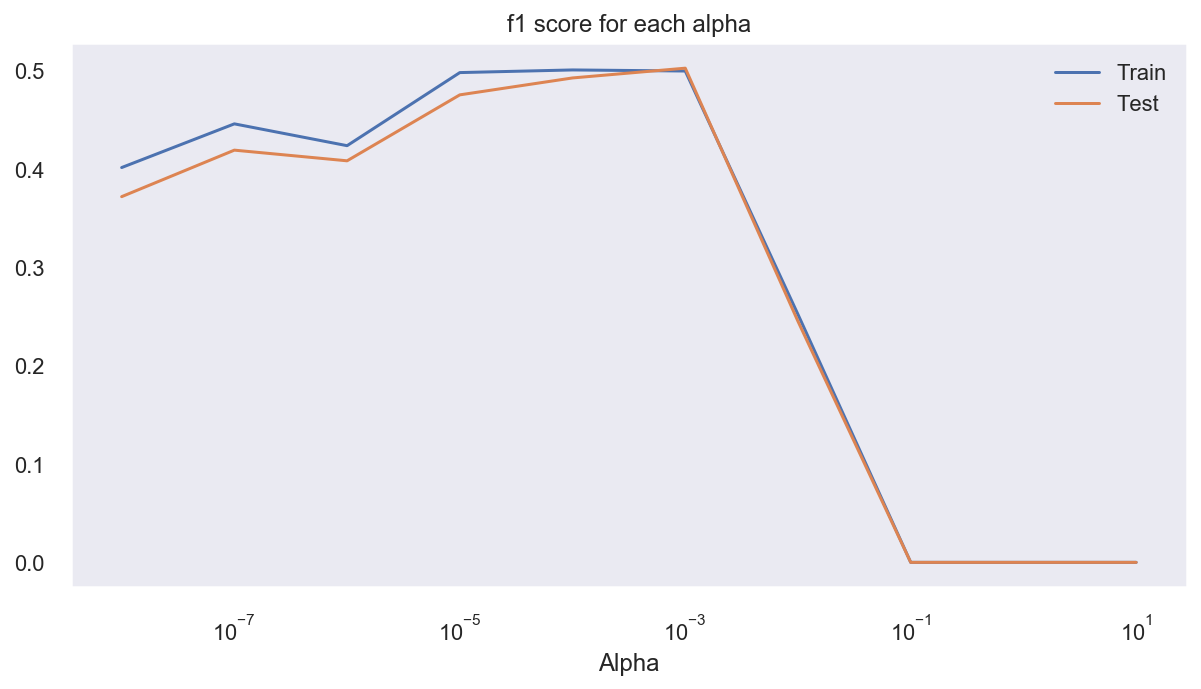

In [233]:
plt.plot(param_grid['alpha'], model.cv_results_['mean_train_score'], label='Train')
plt.plot(param_grid['alpha'], model.cv_results_['mean_test_score'], label='Test')
plt.xscale('log')
plt.grid()
plt.title('f1 score for each alpha')
plt.xlabel('Alpha')
plt.legend() 
plt.show()

### [6.2] AdaBoostClassifier:

In [135]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test={
            'learning_rate': [0.01, 0.05, 0.1, 0.5],
             'n_estimators': sp_randint(10, 400),
            }

In [136]:
adb_clf = AdaBoostClassifier(random_state=32)
adb_clf_rscv = RandomizedSearchCV(estimator=adb_clf, 
                        param_distributions=param_test, 
                        n_iter=10,
                        scoring='f1',
                        cv=StratifiedKFold(n_splits=3,random_state=42, shuffle=True),
                        refit=True, random_state=314, verbose=10, n_jobs=6)
adb_clf_rscv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   31.4s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done  23 out of  30 | elapsed:  3.4min remaining:  1.0min
[Parallel(n_jobs=6)]: Done  27 out of  30 | elapsed:  3.7min remaining:   24.7s
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:  3.8min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
          error_score='raise-deprecating',
          estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=32),
          fit_params=None, iid='warn', n_iter=10, n_jobs=6,
          param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.5], 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D7B1C2FA90>},
          pre_dispatch='2*n_jobs', random_state=314, refit=True,
          return_train_score='warn', scoring='f1', verbose=10)

In [137]:
best_params = adb_clf_rscv.best_params_
adb_clf_final = AdaBoostClassifier(learning_rate = best_params['learning_rate'],
                                   n_estimators = best_params['n_estimators'],
                                   algorithm='SAMME', random_state=0)
adb_clf_final.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.01,
          n_estimators=14, random_state=0)

In [138]:
y_pred = adb_clf_final.predict(X_cv)

print("Accuracy :",accuracy_score(y_cv, y_pred))
print("f1_score :",f1_score(y_cv, y_pred))
print("Hamming loss ",hamming_loss(y_cv,y_pred))
print("Log loss ",log_loss(y_cv,y_pred))

print (classification_report(y_cv, y_pred))

Accuracy : 0.9950543447006729
f1_score : 0.5141242937853107
Hamming loss  0.0049456552993271605
Log loss  0.17081853789578597
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34587
           1       0.56      0.48      0.51       191

   micro avg       1.00      1.00      1.00     34778
   macro avg       0.78      0.74      0.76     34778
weighted avg       0.99      1.00      0.99     34778



In [146]:
confusion_matrix(y_cv, y_pred)

array([[34515,    72],
       [  100,    91]], dtype=int64)

- False Negatives is reduced for AdaBoostClassifier.

### [6.3] LGBMClassifier

In [234]:
import lightgbm as lgb

fit_params={
            "early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_cv,y_cv)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'
            }

In [235]:
param_test={
            'learning_rate': [0.01, 0.05, 0.1, 0.5],
             'n_estimators': sp_randint(10, 150),
             'max_depth': sp_randint(3, 10),
             'num_leaves': sp_randint(6, 40),
             'bagging_fraction': [0.2, 0.5, 0.8],
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 10, 50, 100, 200, 300],
             'reg_lambda': [0, 1e-1, 1, 10, 50, 100, 200, 300],
             #'lambda_l1': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'lambda_l2': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4] 
            }

In [236]:
LGBM_clf = lgb.LGBMClassifier(random_state=314, silent=True, metric='None', #feval=evalerror,
                              #weight=(0.0001,0.9999), 
                              n_jobs=6)
LGBM_clf_rscv = RandomizedSearchCV(estimator=LGBM_clf, 
                        param_distributions=param_test, 
                        n_iter=30,
                        scoring='f1',
                        cv=KFold(n_splits=3,random_state=42, shuffle=True),
                        refit=True, random_state=314, verbose=10)

In [237]:
LGBM_clf_rscv.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(LGBM_clf_rscv.best_score_, LGBM_clf_rscv.best_params_))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] bagging_fraction=0.2, colsample_bytree=0.9827253740513708, lambda_l2=0.1, learning_rate=0.1, max_depth=5, min_child_samples=340, min_child_weight=1000.0, n_estimators=130, num_leaves=28, reg_alpha=300, reg_lambda=0, subsample=0.7947107190594875 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[CV]  bagging_fraction=0.2, colsample_bytree=0.9827253740513708, lambda_l2=0.1, learning_rate=0.1, max_depth=5, min_child_samples=340, min_child_weight=1000.0, n_estimators=130, num_leaves=28, reg_alpha=300, reg_lambda=0, subsample=0.7947107190594875, score=0.0, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] bagging_fraction=0.2, colsample_bytree=0.9827253740513708, lambda_l2=0.1, learning_rate=0.1, max_depth=5, min_child_samples=340, min_child_weight=1000.0, n_estimators=130, num_leaves=28, reg_alpha=300, reg_lambda=0, subsample=0.7947107190594875 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[CV]  bagging_fraction=0.2, colsample_bytree=0.9827253740513708, lambda_l2=0.1, learning_rate=0.1, max_depth=5, min_child_samples=340, min_child_weight=1000.0, n_estimators=130, num_leaves=28, reg_alpha=300, reg_lambda=0, subsample=0.7947107190594875, score=0.0, total=   0.5s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] bagging_fraction=0.2, colsample_bytree=0.9827253740513708, lambda_l2=0.1, learning_rate=0.1, max_depth=5, min_child_samples=340, min_child_weight=1000.0, n_estimators=130, num_leaves=28, reg_alpha=300, reg_lambda=0, subsample=0.7947107190594875 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[CV]  bagging_fraction=0.2, colsample_bytree=0.9827253740513708, lambda_l2=0.1, learning_rate=0.1, max_depth=5, min_child_samples=340, min_child_weight=1000.0, n_estimators=130, num_leaves=28, reg_alpha=300, reg_lambda=0, subsample=0.7947107190594875, score=0.0, total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s


[CV] bagging_fraction=0.8, colsample_bytree=0.5564539333297307, lambda_l2=1, learning_rate=0.01, max_depth=6, min_child_samples=424, min_child_weight=10000.0, n_estimators=98, num_leaves=22, reg_alpha=300, reg_lambda=0.1, subsample=0.4225434881409399 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[CV]  bagging_fraction=0.8, colsample_bytree=0.5564539333297307, lambda_l2=1, learning_rate=0.01, max_depth=6, min_child_samples=424, min_child_weight=10000.0, n_estimators=98, num_leaves=22, reg_alpha=300, reg_lambda=0.1, subsample=0.4225434881409399, score=0.0, total=   0.5s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.1s remaining:    0.0s


[CV] bagging_fraction=0.8, colsample_bytree=0.5564539333297307, lambda_l2=1, learning_rate=0.01, max_depth=6, min_child_samples=424, min_child_weight=10000.0, n_estimators=98, num_leaves=22, reg_alpha=300, reg_lambda=0.1, subsample=0.4225434881409399 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[CV]  bagging_fraction=0.8, colsample_bytree=0.5564539333297307, lambda_l2=1, learning_rate=0.01, max_depth=6, min_child_samples=424, min_child_weight=10000.0, n_estimators=98, num_leaves=22, reg_alpha=300, reg_lambda=0.1, subsample=0.4225434881409399, score=0.0, total=   0.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.9s remaining:    0.0s


[CV] bagging_fraction=0.8, colsample_bytree=0.5564539333297307, lambda_l2=1, learning_rate=0.01, max_depth=6, min_child_samples=424, min_child_weight=10000.0, n_estimators=98, num_leaves=22, reg_alpha=300, reg_lambda=0.1, subsample=0.4225434881409399 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[CV]  bagging_fraction=0.8, colsample_bytree=0.5564539333297307, lambda_l2=1, learning_rate=0.01, max_depth=6, min_child_samples=424, min_child_weight=10000.0, n_estimators=98, num_leaves=22, reg_alpha=300, reg_lambda=0.1, subsample=0.4225434881409399, score=0.0, total=   0.6s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.8s remaining:    0.0s


[CV] bagging_fraction=0.5, colsample_bytree=0.43376169189710756, lambda_l2=100.0, learning_rate=0.5, max_depth=6, min_child_samples=236, min_child_weight=0.01, n_estimators=10, num_leaves=13, reg_alpha=10, reg_lambda=1, subsample=0.513151081329146 
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[7]	valid's auc: 0.864143
[CV]  bagging_fraction=0.5, colsample_bytree=0.43376169189710756, lambda_l2=100.0, learning_rate=0.5, max_depth=6, min_child_samples=236, min_child_weight=0.01, n_estimators=10, num_leaves=13, reg_alpha=10, reg_lambda=1, subsample=0.513151081329146, score=0.0, total=   0.5s


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    5.6s remaining:    0.0s


[CV] bagging_fraction=0.5, colsample_bytree=0.43376169189710756, lambda_l2=100.0, learning_rate=0.5, max_depth=6, min_child_samples=236, min_child_weight=0.01, n_estimators=10, num_leaves=13, reg_alpha=10, reg_lambda=1, subsample=0.513151081329146 
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid's auc: 0.796437
[CV]  bagging_fraction=0.5, colsample_bytree=0.43376169189710756, lambda_l2=100.0, learning_rate=0.5, max_depth=6, min_child_samples=236, min_child_weight=0.01, n_estimators=10, num_leaves=13, reg_alpha=10, reg_lambda=1, subsample=0.513151081329146, score=0.0, total=   0.5s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    6.5s remaining:    0.0s


[CV] bagging_fraction=0.5, colsample_bytree=0.43376169189710756, lambda_l2=100.0, learning_rate=0.5, max_depth=6, min_child_samples=236, min_child_weight=0.01, n_estimators=10, num_leaves=13, reg_alpha=10, reg_lambda=1, subsample=0.513151081329146 
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid's auc: 0.796958
[CV]  bagging_fraction=0.5, colsample_bytree=0.43376169189710756, lambda_l2=100.0, learning_rate=0.5, max_depth=6, min_child_samples=236, min_child_weight=0.01, n_estimators=10, num_leaves=13, reg_alpha=10, reg_lambda=1, subsample=0.513151081329146, score=0.0, total=   0.5s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    7.3s remaining:    0.0s


[CV] bagging_fraction=0.5, colsample_bytree=0.7423313309297233, lambda_l2=100.0, learning_rate=0.05, max_depth=6, min_child_samples=463, min_child_weight=10.0, n_estimators=142, num_leaves=15, reg_alpha=200, reg_lambda=200, subsample=0.8339159749935658 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[CV]  bagging_fraction=0.5, colsample_bytree=0.7423313309297233, lambda_l2=100.0, learning_rate=0.05, max_depth=6, min_child_samples=463, min_child_weight=10.0, n_estimators=142, num_leaves=15, reg_alpha=200, reg_lambda=200, subsample=0.8339159749935658, score=0.0, total=   0.6s
[CV] bagging_fraction=0.5, colsample_bytree=0.7423313309297233, lambda_l2=100.0, learning_rate=0.05, max_depth=6, min_child_samples=463, min_child_weight=10.0, n_estimators=142, num_leaves=15, reg_alpha=200, reg_lambda=200, subsample=0.8339159749935658 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration i

Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[CV]  bagging_fraction=0.8, colsample_bytree=0.6632060030659168, lambda_l2=1e-05, learning_rate=0.5, max_depth=9, min_child_samples=241, min_child_weight=1000.0, n_estimators=67, num_leaves=9, reg_alpha=10, reg_lambda=200, subsample=0.2923888035438325, score=0.0, total=   0.6s
[CV] bagging_fraction=0.8, colsample_bytree=0.6632060030659168, lambda_l2=1e-05, learning_rate=0.5, max_depth=9, min_child_samples=241, min_child_weight=1000.0, n_estimators=67, num_leaves=9, reg_alpha=10, reg_lambda=200, subsample=0.2923888035438325 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[CV]  bagging_fraction=0.8, colsample_bytree=0.6632060030659168, lambda_l2=1e-05, learning_rate=0.5, max_depth=9, min_child_samples=241, min_child_weight=1000.0, n_estimators=67, num_leaves=9, reg_alpha=10, reg_lambda=200, subsample=0

[CV]  bagging_fraction=0.5, colsample_bytree=0.9248818018022084, lambda_l2=0.001, learning_rate=0.01, max_depth=9, min_child_samples=460, min_child_weight=1, n_estimators=125, num_leaves=21, reg_alpha=10, reg_lambda=10, subsample=0.9391518757406234, score=0.0, total=   1.3s
[CV] bagging_fraction=0.5, colsample_bytree=0.9248818018022084, lambda_l2=0.001, learning_rate=0.01, max_depth=9, min_child_samples=460, min_child_weight=1, n_estimators=125, num_leaves=21, reg_alpha=10, reg_lambda=10, subsample=0.9391518757406234 
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.794568
Did not meet early stopping. Best iteration is:
[124]	valid's auc: 0.796027
[CV]  bagging_fraction=0.5, colsample_bytree=0.9248818018022084, lambda_l2=0.001, learning_rate=0.01, max_depth=9, min_child_samples=460, min_child_weight=1, n_estimators=125, num_leaves=21, reg_alpha=10, reg_lambda=10, subsample=0.9391518757406234, score=0.0, total=   1.3s
[CV] bagging_fraction=0.5, colsampl

[CV] bagging_fraction=0.8, colsample_bytree=0.7922607727757143, lambda_l2=100.0, learning_rate=0.01, max_depth=9, min_child_samples=433, min_child_weight=10000.0, n_estimators=87, num_leaves=23, reg_alpha=0.1, reg_lambda=200, subsample=0.6966987488097254 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[CV]  bagging_fraction=0.8, colsample_bytree=0.7922607727757143, lambda_l2=100.0, learning_rate=0.01, max_depth=9, min_child_samples=433, min_child_weight=10000.0, n_estimators=87, num_leaves=23, reg_alpha=0.1, reg_lambda=200, subsample=0.6966987488097254, score=0.0, total=   0.5s
[CV] bagging_fraction=0.8, colsample_bytree=0.7922607727757143, lambda_l2=100.0, learning_rate=0.01, max_depth=9, min_child_samples=433, min_child_weight=10000.0, n_estimators=87, num_leaves=23, reg_alpha=0.1, reg_lambda=200, subsample=0.6966987488097254 
Training until validation scores don't improve for 30 rounds.
Early stopping, best itera

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.5min finished


Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[12]	valid's auc: 0.849426
Best score reached: 0.1733931240657698 with params: {'bagging_fraction': 0.5, 'colsample_bytree': 0.7843976983964338, 'lambda_l2': 1e-05, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_samples': 235, 'min_child_weight': 0.001, 'n_estimators': 13, 'num_leaves': 22, 'reg_alpha': 50, 'reg_lambda': 10, 'subsample': 0.4496581415110803} 


In [238]:
best_params = LGBM_clf_rscv.best_params_

In [239]:
LGBM_clf_final = lgb.LGBMClassifier(**LGBM_clf.get_params())
#set optimal parameters
LGBM_clf_final.set_params(**best_params)
LGBM_clf_final.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[12]	valid's auc: 0.849426


LGBMClassifier(bagging_fraction=0.5, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7843976983964338, importance_type='split',
        lambda_l2=1e-05, learning_rate=0.1, max_depth=4, metric='None',
        min_child_samples=235, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=13, n_jobs=6, num_leaves=22, objective=None,
        random_state=314, reg_alpha=50, reg_lambda=10, silent=True,
        subsample=0.4496581415110803, subsample_for_bin=200000,
        subsample_freq=0)

In [240]:
y_pred = LGBM_clf_final.predict(X_cv)

print("Accuracy :",accuracy_score(y_cv, y_pred))
print("f1_score :",f1_score(y_cv, y_pred))
print("Hamming loss ",hamming_loss(y_cv,y_pred))
print("Log loss ",log_loss(y_cv,y_pred))

print (classification_report(y_cv, y_pred))

Accuracy : 0.9950543447006729
f1_score : 0.5141242937853107
Hamming loss  0.0049456552993271605
Log loss  0.17081853789578597
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34587
           1       0.56      0.48      0.51       191

   micro avg       1.00      1.00      1.00     34778
   macro avg       0.78      0.74      0.76     34778
weighted avg       0.99      1.00      0.99     34778



- The F1 score seems to improve significantly for LGBC.

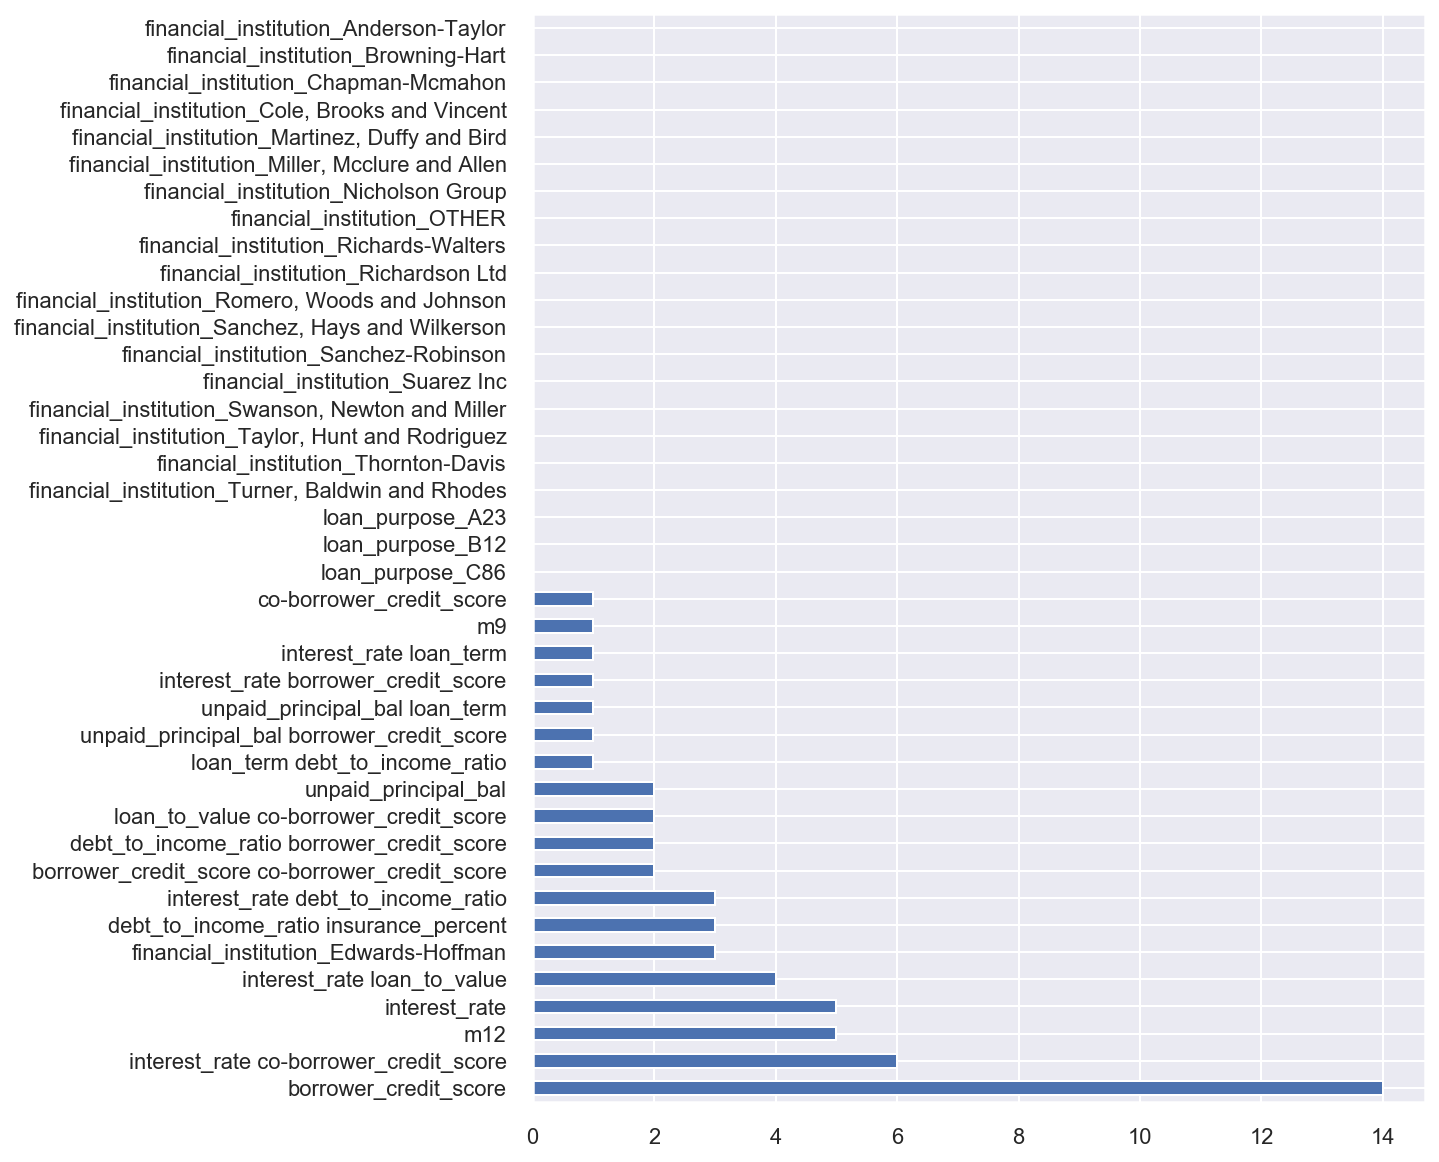

In [241]:
#For plotting feature importance
feat_imp = pd.Series(LGBM_clf_final.feature_importances_, index=df_train_ohe.columns)
feat_imp.nlargest(40, keep='last').plot(kind='barh', figsize=(8,10))

- Interestingly, some of the combined features seems to among top important features.

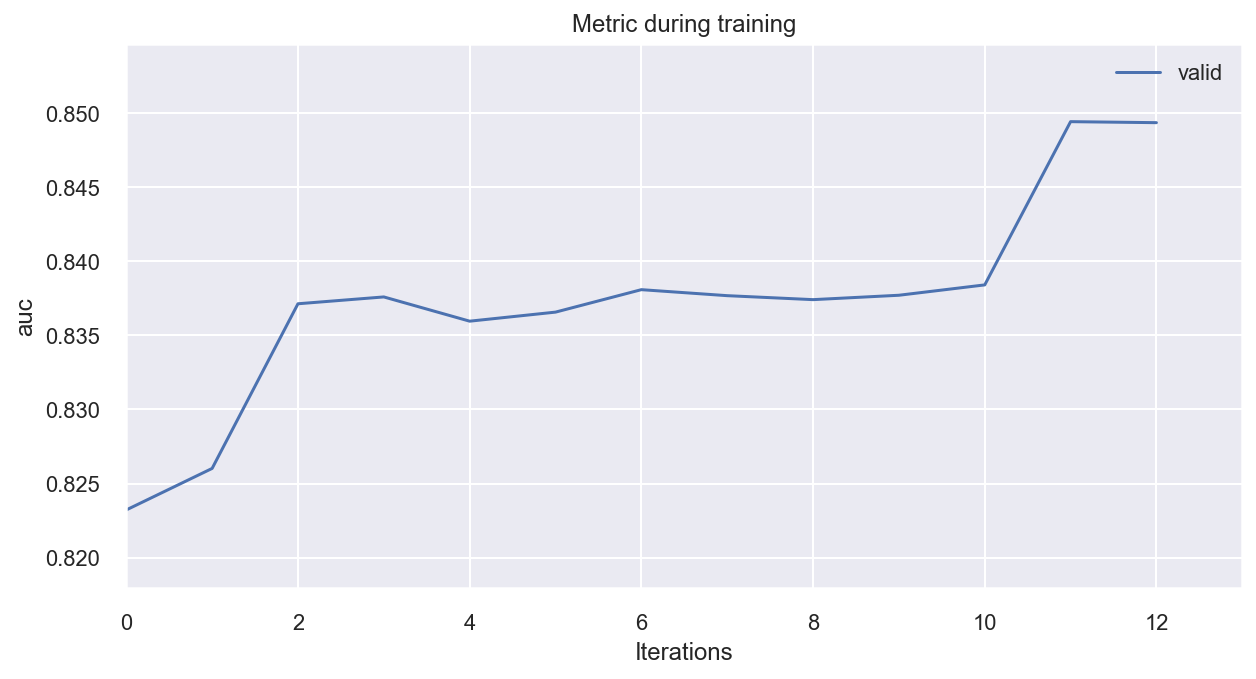

In [242]:
lgb.plot_metric(LGBM_clf_final, metric=None, dataset_names=None, title='Metric during training', xlabel='Iterations', ylabel='auto', figsize=None, grid=True)

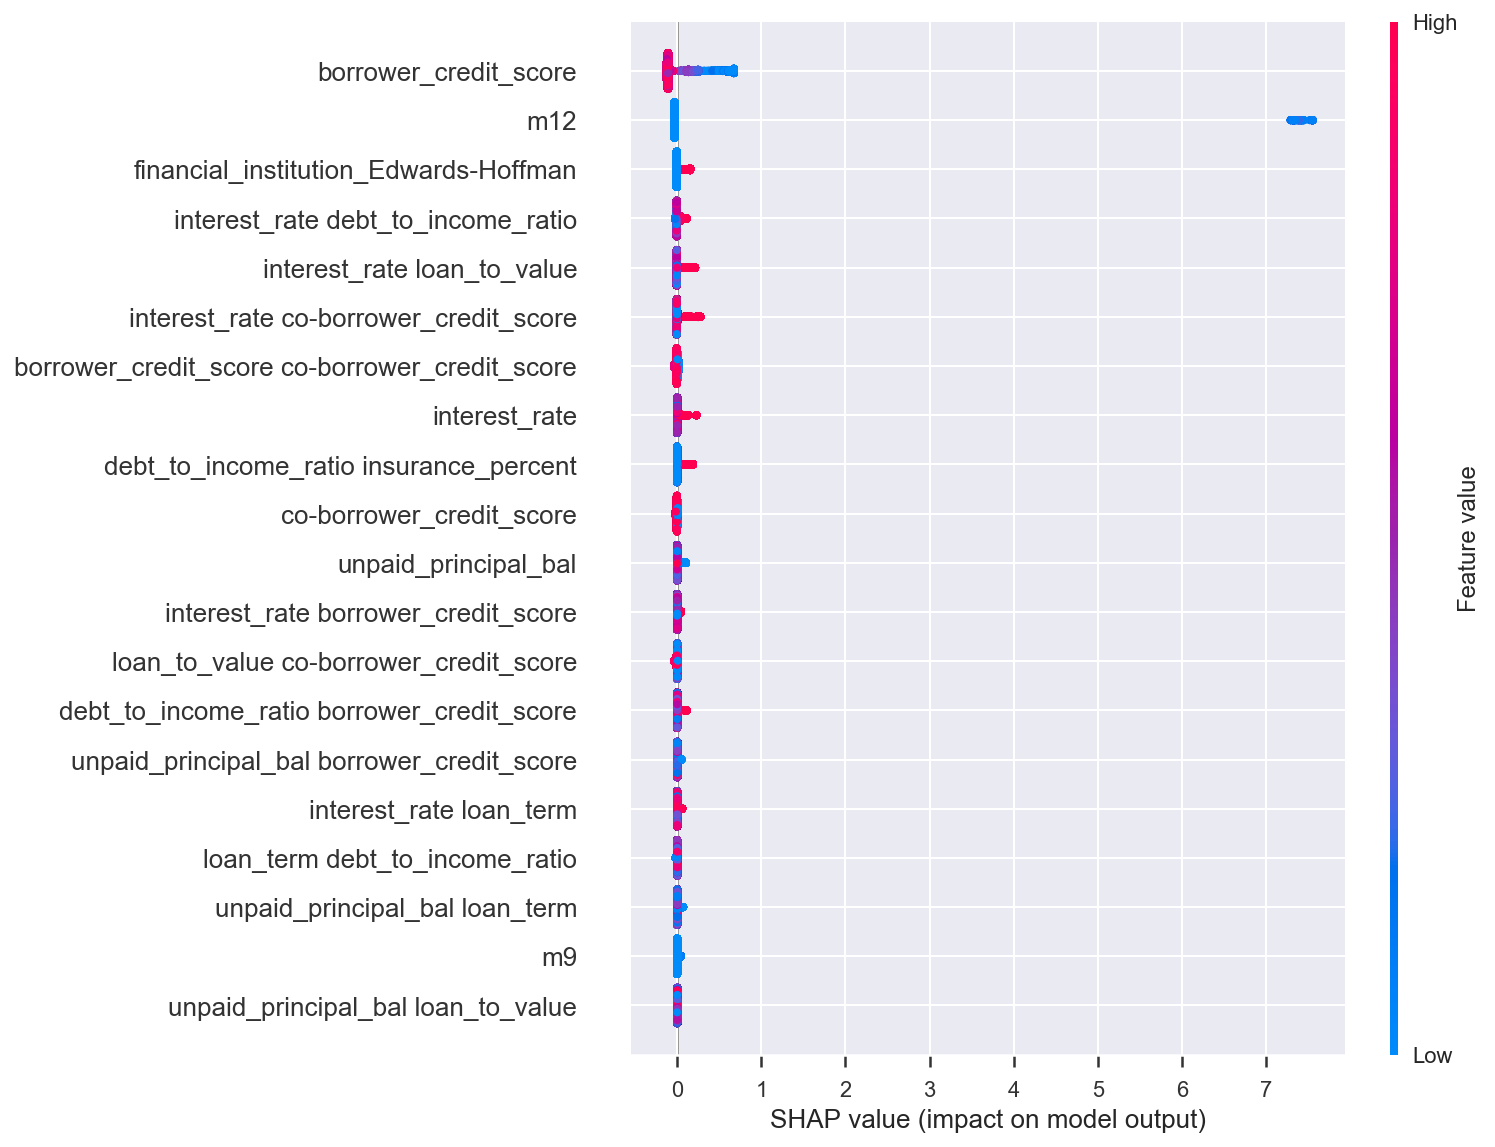

In [77]:
import shap
shap.initjs()

shap_values = shap.TreeExplainer(LGBM_clf_final.booster_).shap_values(X_train)

shap.summary_plot(shap_values, X_train)

- Except borrower_credit_score and m12 most other features dont seem to have much of an impact on our model.

#### Taking only Top n most important features

In [292]:
n=15

In [293]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_cv[feat_imp.nlargest(n).index],y_cv)], #taking only top 30 most important features.
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 200,
            'categorical_feature': 'auto'}

In [294]:
#taking only top 30 most important features.
LGBM_clf_rscv.fit(X_train[feat_imp.nlargest(n).index], y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(LGBM_clf_rscv.best_score_, LGBM_clf_rscv.best_params_))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] bagging_fraction=0.2, colsample_bytree=0.9827253740513708, lambda_l2=0.1, learning_rate=0.1, max_depth=5, min_child_samples=340, min_child_weight=1000.0, n_estimators=130, num_leaves=28, reg_alpha=300, reg_lambda=0, subsample=0.7947107190594875 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[CV]  bagging_fraction=0.2, colsample_bytree=0.9827253740513708, lambda_l2=0.1, learning_rate=0.1, max_depth=5, min_child_samples=340, min_child_weight=1000.0, n_estimators=130, num_leaves=28, reg_alpha=300, reg_lambda=0, subsample=0.7947107190594875, score=0.0, total=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] bagging_fraction=0.2, colsample_bytree=0.9827253740513708, lambda_l2=0.1, learning_rate=0.1, max_depth=5, min_child_samples=340, min_child_weight=1000.0, n_estimators=130, num_leaves=28, reg_alpha=300, reg_lambda=0, subsample=0.7947107190594875 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[CV]  bagging_fraction=0.2, colsample_bytree=0.9827253740513708, lambda_l2=0.1, learning_rate=0.1, max_depth=5, min_child_samples=340, min_child_weight=1000.0, n_estimators=130, num_leaves=28, reg_alpha=300, reg_lambda=0, subsample=0.7947107190594875, score=0.0, total=   0.6s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] bagging_fraction=0.2, colsample_bytree=0.9827253740513708, lambda_l2=0.1, learning_rate=0.1, max_depth=5, min_child_samples=340, min_child_weight=1000.0, n_estimators=130, num_leaves=28, reg_alpha=300, reg_lambda=0, subsample=0.7947107190594875 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[CV]  bagging_fraction=0.2, colsample_bytree=0.9827253740513708, lambda_l2=0.1, learning_rate=0.1, max_depth=5, min_child_samples=340, min_child_weight=1000.0, n_estimators=130, num_leaves=28, reg_alpha=300, reg_lambda=0, subsample=0.7947107190594875, score=0.0, total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s


[CV] bagging_fraction=0.8, colsample_bytree=0.5564539333297307, lambda_l2=1, learning_rate=0.01, max_depth=6, min_child_samples=424, min_child_weight=10000.0, n_estimators=98, num_leaves=22, reg_alpha=300, reg_lambda=0.1, subsample=0.4225434881409399 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[CV]  bagging_fraction=0.8, colsample_bytree=0.5564539333297307, lambda_l2=1, learning_rate=0.01, max_depth=6, min_child_samples=424, min_child_weight=10000.0, n_estimators=98, num_leaves=22, reg_alpha=300, reg_lambda=0.1, subsample=0.4225434881409399, score=0.0, total=   0.3s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.0s remaining:    0.0s


[CV] bagging_fraction=0.8, colsample_bytree=0.5564539333297307, lambda_l2=1, learning_rate=0.01, max_depth=6, min_child_samples=424, min_child_weight=10000.0, n_estimators=98, num_leaves=22, reg_alpha=300, reg_lambda=0.1, subsample=0.4225434881409399 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[CV]  bagging_fraction=0.8, colsample_bytree=0.5564539333297307, lambda_l2=1, learning_rate=0.01, max_depth=6, min_child_samples=424, min_child_weight=10000.0, n_estimators=98, num_leaves=22, reg_alpha=300, reg_lambda=0.1, subsample=0.4225434881409399, score=0.0, total=   0.4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s


[CV] bagging_fraction=0.8, colsample_bytree=0.5564539333297307, lambda_l2=1, learning_rate=0.01, max_depth=6, min_child_samples=424, min_child_weight=10000.0, n_estimators=98, num_leaves=22, reg_alpha=300, reg_lambda=0.1, subsample=0.4225434881409399 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[CV]  bagging_fraction=0.8, colsample_bytree=0.5564539333297307, lambda_l2=1, learning_rate=0.01, max_depth=6, min_child_samples=424, min_child_weight=10000.0, n_estimators=98, num_leaves=22, reg_alpha=300, reg_lambda=0.1, subsample=0.4225434881409399, score=0.0, total=   0.4s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.2s remaining:    0.0s


[CV] bagging_fraction=0.5, colsample_bytree=0.43376169189710756, lambda_l2=100.0, learning_rate=0.5, max_depth=6, min_child_samples=236, min_child_weight=0.01, n_estimators=10, num_leaves=13, reg_alpha=10, reg_lambda=1, subsample=0.513151081329146 
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[9]	valid's auc: 0.871178
[CV]  bagging_fraction=0.5, colsample_bytree=0.43376169189710756, lambda_l2=100.0, learning_rate=0.5, max_depth=6, min_child_samples=236, min_child_weight=0.01, n_estimators=10, num_leaves=13, reg_alpha=10, reg_lambda=1, subsample=0.513151081329146, score=0.0, total=   0.3s


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.7s remaining:    0.0s


[CV] bagging_fraction=0.5, colsample_bytree=0.43376169189710756, lambda_l2=100.0, learning_rate=0.5, max_depth=6, min_child_samples=236, min_child_weight=0.01, n_estimators=10, num_leaves=13, reg_alpha=10, reg_lambda=1, subsample=0.513151081329146 
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid's auc: 0.797312
[CV]  bagging_fraction=0.5, colsample_bytree=0.43376169189710756, lambda_l2=100.0, learning_rate=0.5, max_depth=6, min_child_samples=236, min_child_weight=0.01, n_estimators=10, num_leaves=13, reg_alpha=10, reg_lambda=1, subsample=0.513151081329146, score=0.0, total=   0.2s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.1s remaining:    0.0s


[CV] bagging_fraction=0.5, colsample_bytree=0.43376169189710756, lambda_l2=100.0, learning_rate=0.5, max_depth=6, min_child_samples=236, min_child_weight=0.01, n_estimators=10, num_leaves=13, reg_alpha=10, reg_lambda=1, subsample=0.513151081329146 
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[10]	valid's auc: 0.789904
[CV]  bagging_fraction=0.5, colsample_bytree=0.43376169189710756, lambda_l2=100.0, learning_rate=0.5, max_depth=6, min_child_samples=236, min_child_weight=0.01, n_estimators=10, num_leaves=13, reg_alpha=10, reg_lambda=1, subsample=0.513151081329146, score=0.0, total=   0.2s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.5s remaining:    0.0s


[CV] bagging_fraction=0.5, colsample_bytree=0.7423313309297233, lambda_l2=100.0, learning_rate=0.05, max_depth=6, min_child_samples=463, min_child_weight=10.0, n_estimators=142, num_leaves=15, reg_alpha=200, reg_lambda=200, subsample=0.8339159749935658 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[CV]  bagging_fraction=0.5, colsample_bytree=0.7423313309297233, lambda_l2=100.0, learning_rate=0.05, max_depth=6, min_child_samples=463, min_child_weight=10.0, n_estimators=142, num_leaves=15, reg_alpha=200, reg_lambda=200, subsample=0.8339159749935658, score=0.0, total=   0.2s
[CV] bagging_fraction=0.5, colsample_bytree=0.7423313309297233, lambda_l2=100.0, learning_rate=0.05, max_depth=6, min_child_samples=463, min_child_weight=10.0, n_estimators=142, num_leaves=15, reg_alpha=200, reg_lambda=200, subsample=0.8339159749935658 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration i

Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[CV]  bagging_fraction=0.8, colsample_bytree=0.6632060030659168, lambda_l2=1e-05, learning_rate=0.5, max_depth=9, min_child_samples=241, min_child_weight=1000.0, n_estimators=67, num_leaves=9, reg_alpha=10, reg_lambda=200, subsample=0.2923888035438325, score=0.0, total=   0.1s
[CV] bagging_fraction=0.8, colsample_bytree=0.6632060030659168, lambda_l2=1e-05, learning_rate=0.5, max_depth=9, min_child_samples=241, min_child_weight=1000.0, n_estimators=67, num_leaves=9, reg_alpha=10, reg_lambda=200, subsample=0.2923888035438325 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[CV]  bagging_fraction=0.8, colsample_bytree=0.6632060030659168, lambda_l2=1e-05, learning_rate=0.5, max_depth=9, min_child_samples=241, min_child_weight=1000.0, n_estimators=67, num_leaves=9, reg_alpha=10, reg_lambda=200, subsample=0

[CV] bagging_fraction=0.5, colsample_bytree=0.9248818018022084, lambda_l2=0.001, learning_rate=0.01, max_depth=9, min_child_samples=460, min_child_weight=1, n_estimators=125, num_leaves=21, reg_alpha=10, reg_lambda=10, subsample=0.9391518757406234 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[13]	valid's auc: 0.789947
[CV]  bagging_fraction=0.5, colsample_bytree=0.9248818018022084, lambda_l2=0.001, learning_rate=0.01, max_depth=9, min_child_samples=460, min_child_weight=1, n_estimators=125, num_leaves=21, reg_alpha=10, reg_lambda=10, subsample=0.9391518757406234, score=0.0, total=   0.2s
[CV] bagging_fraction=0.5, colsample_bytree=0.9248818018022084, lambda_l2=0.001, learning_rate=0.01, max_depth=9, min_child_samples=460, min_child_weight=1, n_estimators=125, num_leaves=21, reg_alpha=10, reg_lambda=10, subsample=0.9391518757406234 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[63]	v

[CV] bagging_fraction=0.8, colsample_bytree=0.7922607727757143, lambda_l2=100.0, learning_rate=0.01, max_depth=9, min_child_samples=433, min_child_weight=10000.0, n_estimators=87, num_leaves=23, reg_alpha=0.1, reg_lambda=200, subsample=0.6966987488097254 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[CV]  bagging_fraction=0.8, colsample_bytree=0.7922607727757143, lambda_l2=100.0, learning_rate=0.01, max_depth=9, min_child_samples=433, min_child_weight=10000.0, n_estimators=87, num_leaves=23, reg_alpha=0.1, reg_lambda=200, subsample=0.6966987488097254, score=0.0, total=   0.2s
[CV] bagging_fraction=0.8, colsample_bytree=0.5864490636095279, lambda_l2=0.001, learning_rate=0.01, max_depth=9, min_child_samples=143, min_child_weight=1e-05, n_estimators=128, num_leaves=13, reg_alpha=50, reg_lambda=0, subsample=0.503765344235642 
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration 

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   38.6s finished


Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[5]	valid's auc: 0.85701
Best score reached: 0.1733931240657698 with params: {'bagging_fraction': 0.5, 'colsample_bytree': 0.7843976983964338, 'lambda_l2': 1e-05, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_samples': 235, 'min_child_weight': 0.001, 'n_estimators': 13, 'num_leaves': 22, 'reg_alpha': 50, 'reg_lambda': 10, 'subsample': 0.4496581415110803} 


In [295]:
best_params = LGBM_clf_rscv.best_params_

In [296]:
#taking only top 30 most important features.
LGBM_clf_final = lgb.LGBMClassifier(**LGBM_clf.get_params())
#set optimal parameters
LGBM_clf_final.set_params(**best_params)
LGBM_clf_final.fit(X_train[feat_imp.nlargest(n).index], y_train, **fit_params)

Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[5]	valid's auc: 0.85701


LGBMClassifier(bagging_fraction=0.5, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7843976983964338, importance_type='split',
        lambda_l2=1e-05, learning_rate=0.1, max_depth=4, metric='None',
        min_child_samples=235, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=13, n_jobs=6, num_leaves=22, objective=None,
        random_state=314, reg_alpha=50, reg_lambda=10, silent=True,
        subsample=0.4496581415110803, subsample_for_bin=200000,
        subsample_freq=0)

In [297]:
y_pred = LGBM_clf_final.predict(X_cv[feat_imp.nlargest(n).index])

print("Accuracy :",accuracy_score(y_cv, y_pred))
print("f1_score :",f1_score(y_cv, y_pred))
print("Hamming loss ",hamming_loss(y_cv,y_pred))
print("Log loss ",log_loss(y_cv,y_pred))

print (classification_report(y_cv, y_pred))

Accuracy : 0.9950543447006729
f1_score : 0.5141242937853107
Hamming loss  0.0049456552993271605
Log loss  0.17081853789578597
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34587
           1       0.56      0.48      0.51       191

   micro avg       1.00      1.00      1.00     34778
   macro avg       0.78      0.74      0.76     34778
weighted avg       0.99      1.00      0.99     34778



- The F1 score doesn't improve significantly for LGBC with Top n features.

In [120]:
if n = len(X_train.columns):
    final_pred = LGBM_clf_final.predict(df_test_ohe) #Taking all the features and predicting
else:
    final_pred = LGBM_clf_final.predict(df_test_ohe[feat_imp.nlargest(n).index]) #Taking Top n features and predicting
#final_pred = model.predict(X_test_standardized)
Submissions = pd.DataFrame()
Submissions['loan_id'] = test_loan_id
Submissions['m13'] = final_pred

In [121]:
Submissions.to_csv('Submissions.csv',index=False)

In [122]:
#LGBC Imbalanced Poly and OHE, Considering all features.
Submissions['m13'].value_counts()

0    35724
1      142
Name: m13, dtype: int64

## Considering categorical features for CatBoost.

In [243]:
# find out the indices of categorical variables
categorical_var = np.where(df_train.dtypes == np.object)[0]

#### Oversampling the minority class:

In [255]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_true==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_true==0)))

#sm = SMOTE(random_state=2)
sm = SMOTENC(random_state=2, categorical_features=categorical_var) #experimenting with different Oversampling techniques
X_train_smote, y_train_smote = sm.fit_sample(df_train.drop('m13',1), y_true.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_smote.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_smote.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_smote==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_smote==0)))

Before OverSampling, counts of label '1': 635
Before OverSampling, counts of label '0': 115290 

After OverSampling, the shape of train_X: (230580, 24)
After OverSampling, the shape of train_y: (230580,) 

After OverSampling, counts of label '1': 115290
After OverSampling, counts of label '0': 115290


In [256]:
X_train,X_cv,y_train,y_cv = train_test_split(X_train_smote, y_train_smote, stratify = y_train_smote,
                                             test_size=0.3,random_state = 42)

In [257]:
#Converting X_train and X_cv to DataFrames.
X_train = pd.DataFrame(X_train, columns=df_train.drop('m13',1).columns)
X_cv = pd.DataFrame(X_cv, columns=df_train.drop('m13',1).columns)

### Catboost tuning hyperparameters

In [258]:
from catboost import CatBoost
import catboost as ctb
fit_params={
            "early_stopping_rounds":30, 
            #"eval_metric" : 'auc', 
            "eval_set" : [(X_cv,y_cv)],
            #'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': False#,
            #'plot': True
            #'categorical_feature': 'auto'
            }

In [259]:
param_test={
            'learning_rate': [0.01, 0.05, 0.1, 0.5],
             'n_estimators': sp_randint(10, 150),
             'max_depth': sp_randint(3, 10)#,
             #'num_leaves': sp_randint(6, 40)#,
             #'bagging_fraction': [0.2, 0.5, 0.8],
             #'min_child_samples': sp_randint(100, 500), 
             #'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             #'subsample': sp_uniform(loc=0.2, scale=0.8), 
             #'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             #'reg_alpha': [0, 1e-1, 1, 10, 50, 100, 200, 300],
             #'reg_lambda': [0, 1e-1, 1, 10, 50, 100, 200, 300],
             #'lambda_l1': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             #'lambda_l2': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4] 
            }

In [260]:
catboost_clf = ctb.CatBoostClassifier(random_state=314, silent=True,# metric='None', 
                                           use_best_model=True,
                                           #task_type="GPU",
                                           #weight=(0.0001,0.9999),
                                           cat_features=categorical_var#,
                                           #n_jobs=6
                                     )
catboost_clf_rscv = RandomizedSearchCV(estimator=catboost_clf, 
                        param_distributions=param_test, 
                        n_iter=10,
                        scoring='f1',
                        cv=StratifiedKFold(n_splits=3,random_state=42, shuffle=True),
                        refit=True, random_state=314, verbose=10)

In [261]:
catboost_clf_rscv.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(catboost_clf_rscv.best_score_, catboost_clf_rscv.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.01, max_depth=8, n_estimators=96 ................
[CV]  learning_rate=0.01, max_depth=8, n_estimators=96, score=0.949469115709525, total=  14.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.7s remaining:    0.0s


[CV] learning_rate=0.01, max_depth=8, n_estimators=96 ................
[CV]  learning_rate=0.01, max_depth=8, n_estimators=96, score=0.9487174515772535, total=  14.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   29.5s remaining:    0.0s


[CV] learning_rate=0.01, max_depth=8, n_estimators=96 ................
[CV]  learning_rate=0.01, max_depth=8, n_estimators=96, score=0.949973874170263, total=  13.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   44.1s remaining:    0.0s


[CV] learning_rate=0.1, max_depth=9, n_estimators=17 .................
[CV]  learning_rate=0.1, max_depth=9, n_estimators=17, score=0.9604541444516896, total=   4.6s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   49.5s remaining:    0.0s


[CV] learning_rate=0.1, max_depth=9, n_estimators=17 .................
[CV]  learning_rate=0.1, max_depth=9, n_estimators=17, score=0.9610010747735298, total=   4.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.9s remaining:    0.0s


[CV] learning_rate=0.1, max_depth=9, n_estimators=17 .................
[CV]  learning_rate=0.1, max_depth=9, n_estimators=17, score=0.9623053078718763, total=   4.6s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.0min remaining:    0.0s


[CV] learning_rate=0.1, max_depth=5, n_estimators=130 ................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=130, score=0.9875904472687737, total=  13.0s


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s


[CV] learning_rate=0.1, max_depth=5, n_estimators=130 ................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=130, score=0.9863456228987848, total=  13.0s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.5min remaining:    0.0s


[CV] learning_rate=0.1, max_depth=5, n_estimators=130 ................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=130, score=0.9876057077497141, total=  12.9s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.7min remaining:    0.0s


[CV] learning_rate=0.1, max_depth=3, n_estimators=118 ................
[CV]  learning_rate=0.1, max_depth=3, n_estimators=118, score=0.9737834815081606, total=   9.8s
[CV] learning_rate=0.1, max_depth=3, n_estimators=118 ................
[CV]  learning_rate=0.1, max_depth=3, n_estimators=118, score=0.9728805834092981, total=   9.8s
[CV] learning_rate=0.1, max_depth=3, n_estimators=118 ................
[CV]  learning_rate=0.1, max_depth=3, n_estimators=118, score=0.9749175917857007, total=   9.8s
[CV] learning_rate=0.1, max_depth=3, n_estimators=14 .................
[CV]  learning_rate=0.1, max_depth=3, n_estimators=14, score=0.9215522720050842, total=   2.9s
[CV] learning_rate=0.1, max_depth=3, n_estimators=14 .................
[CV]  learning_rate=0.1, max_depth=3, n_estimators=14, score=0.9168584292146073, total=   3.0s
[CV] learning_rate=0.1, max_depth=3, n_estimators=14 .................
[CV]  learning_rate=0.1, max_depth=3, n_estimators=14, score=0.9215682382133994, total=   3.0s
[

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  5.6min finished


Best score reached: 0.9972540710125151 with params: {'learning_rate': 0.5, 'max_depth': 9, 'n_estimators': 133} 


In [262]:
best_params = catboost_clf_rscv.best_params_

In [263]:
catboost_clf_final = ctb.CatBoostClassifier(**catboost_clf.get_params(), custom_loss=['F1','AUC']) #Metric should be uppercase for F1 and AUC
#set optimal parameters
catboost_clf_final.set_params(**best_params)
catboost_clf_final.fit(X_train, y_train,
                       eval_set=[(X_cv,y_cv)],
                       early_stopping_rounds=30,
                       verbose=False, 
                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [264]:
y_pred = catboost_clf_final.predict(X_cv)

print("Accuracy :",accuracy_score(y_cv, y_pred))
print("f1_score :",f1_score(y_cv, y_pred))
print("Hamming loss ",hamming_loss(y_cv,y_pred))
print("Log loss ",log_loss(y_cv,y_pred))

print (classification_report(y_cv, y_pred))

Accuracy : 0.9974123225489345
f1_score : 0.9974110125978102
Hamming loss  0.0025876774510654294
Log loss  0.08937604512828597
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34587
           1       1.00      1.00      1.00     34587

   micro avg       1.00      1.00      1.00     69174
   macro avg       1.00      1.00      1.00     69174
weighted avg       1.00      1.00      1.00     69174



In [267]:
final_pred_ctb = catboost_clf_final.predict(df_test)

In [268]:
Counter(final_pred_ctb)

Counter({0.0: 35726, 1.0: 140})